In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import networkx as nx
from datetime import datetime

In [3]:
import analysis as an

In [4]:
obsfile = 'Observation-dataTable-2022-ALL.xlsx'
monday170 = pd.read_excel(obsfile, 'PHY170 Mon', header=10, nrows=60-11)
thursday170 = pd.read_excel(obsfile, 'PHY170 Thurs', header=10, nrows = 66-11)
tuesday150_8am_1 = pd.read_excel(obsfile, 'PHY150 8am Tues Obs1', header=10, nrows=60-11)
# tuesday150_8am_2 = pd.read_excel(obsfile, 'PHY150 8am Tues Obs2',header=11, nrows=97-11)
tuesday150_8am_2 = pd.read_csv('PHY150_8am_Tues_Obs2.csv', header=10)
tuesday150_9am = pd.read_excel(obsfile, 'PHY150 9am Tues', header=10, nrows=68-11)
tuesday150_1pm = pd.read_excel(obsfile, 'PHY150 1pm Tues', header=10, nrows=140-11)
wednesday150_9am_1 = pd.read_excel(obsfile, 'PHY150 9am Wed Obs1 ', header=10, nrows=68-11)
wednesday150_9am_2 = pd.read_excel(obsfile, 'PHY150 9am Wed Obs2', header=10, nrows=66-11)
wednesday150_1pm = pd.read_excel(obsfile, 'PHY150 1pm Wed', header=10, nrows=149-18)

#### Column Format
- `t0`- time of activity
- `a` - type of classroom activity
- `n` - table number for interaction
- `S` - student initiated
- `T` - TA initiated
- `I` - Instructor initiated
- `U` - Unclear initiator
- `ID`- TA/Instructor ID
- `t` - start time of interaction
- `o` - time order
- `l` - interaction length
- `c` - comments

# Foundational Code

## Generic Code

In [7]:
def rename_columns(df):
    """
    Returns
    -------
    renamed_df : pd.DataFrame
        DataFrame with renamed columns
    """
    oldcolnames = list(df.columns)
    newcolnames = ['t0','a','n','S','T','I','U','ID','t','torder','l','c']
    renamed_df = df.rename(columns = {old : new for old, new in zip(*(oldcolnames, newcolnames))}).convert_dtypes()
    # renamed_df['t'] = renamed_df['t'].apply(lambda x: pd.Timestamp(str(x)))
    return renamed_df
    
def fill_col(df, col):
    """
    Returns
    -------
    fill_df : pd.DataFrame
        DataFrame with `col` filled
        (i.e. no NaNs)
    """
    new = []
    for i, row in df.iterrows():
        if pd.isna(row[col]):
            new.append(new[-1])
            # filled = False
            # idx = i
            # while not filled:
            #     idx -= 1
            #     if ~pd.isna(df.loc[idx, col]):
            #         new.append(df.loc[idx, col])
            #         filled = True
        else:
            new.append(row[col])
    df[col] = new
    return df

In [165]:
def tuesday_data():
    tu_ = [
        rename_columns(tuesday150_8am_1).fillna({init:0 for init in 'STIU'}), 
        tuesday150_8am_2, 
        rename_columns(tuesday150_9am).fillna({init:0 for init in 'STIU'}), 
        tuesday150_1pm]
    
    # TUESDAY 8AM OBS 1
    tu_[0] = fill_col(fill_col(tu_[0], col='t0'), col='a')
    tu_[0] = tu_[0].iloc[np.where(~pd.isna(tu_[0]['n']))]
    tu_[0].loc[tu_[0]['a'].str.contains('Table 3 all left'), 'a'] = 'Group Assignment'
    tu_[0].loc[44, 'ID'] = 'I'
    tu_[0].loc[47, 'ID'] = 'I'
    tu_[0]['ID'] = ['I' if ((pd.isna(row['ID'])) & (row['I'] == 1)) else row['ID'] for i, row in tu_[0].iterrows()]
    mods = []
    for i, row in tu_[0].loc[((pd.isna(tu_[0]['ID'])) & (tu_[0]['S'] == 1))].iterrows():
        modtuple = []
        modtuple.append(i)
        modtuple.append('ID')
        if 'instructor' in row['c']:
            modtuple.append('I')
        elif 'TA B' in row['c']:
            modtuple.append('B')
        mods.append(tuple(modtuple))
    for mt in mods:
        tu_[0].loc[mt[0], mt[1]] = mt[2]
    tu_[0]['ID'] = tu_[0]['ID'].apply(lambda x: 'I' if x=='instructor' else x)
    
    tu0idmap = {
        'A':'R',
        'B':'L'
    }
    tu_[0]['ID'] = tu_[0]['ID'].apply(lambda x: tu0idmap[x] if x in tu0idmap.keys() else x)
    # tu_[0]['t'] = tu_[0]['t'].apply(pd.Timestamp)
    
    
    # TUESDAY 8AM OBS 2
    tu_[1] = tu_[1].assign(torder = [i + 1 for i in range(len(tu_[1]))])
    listobj = list(tu_[1].columns)[:-1]
    listobj.insert(-2, list(tu_[1].columns)[-1])
    tu_[1] = tu_[1][listobj]
    # tu_[1] = rename_columns(tu_[1][listobj])
    # remove all observations where table number == "all",
    # because none of the other observers considered the instructor addressing
    # all tables as an interaction
    tu_[1] = tu_[1].loc[tu_[1][tu_[1].columns[2]]!='all']
    tu_[1][tu_[1].columns[8]] = tu_[1][tu_[1].columns[8]].apply(lambda x: 0 if pd.isna(x) else 1)
    tu_[1][tu_[1].columns[9]] = tu_[1][tu_[1].columns[9]].fillna('I')
    for col in [3,4,5,6,7,8]:
        tu_[1][tu_[1].columns[col]] = tu_[1][tu_[1].columns[col]].apply(lambda x: 0 if pd.isna(x) else int(x))
    # fill in missing column values
    tu_[1] = fill_col(fill_col(tu_[1], col=tu_[1].columns[0]), col=tu_[1].columns[10])
    cols = {i:col for i, col in enumerate(tu_[1].columns)}
    tu_1ids=[int(bool(((row[cols[3]]==1) or (row[cols[4]])))) for i, row in tu_[1].iterrows()]
    tu_1cols = list(tu_[1].columns[:3]) + ['S'] + list(tu_[1].columns[6:])
    tu_[1] = tu_[1].assign(S=tu_1ids)
    tu_[1] = tu_[1][tu_1cols]
    tu_[1] = rename_columns(tu_[1])
    
    # remove rows where the table number is `NaN` AND no interaction occurs
    tu1badidx = list(tu_[1].loc[((pd.isna(tu_[1]['n'])) & (sum([tu_[1]['S'],tu_[1]['T'],tu_[1]['I'],tu_[1]['U']])==0))].index)
    tu_[1] = tu_[1].loc[~tu_[1].index.isin(tu1badidx)]
    
    # remove rows where TA/Instructors are handing out rulers, because TUESDAY 8AM OBS 1 didn't
    # consider that an interaction (according to lack of "ruler" substring in their comments column)
    tu1ruleridx = list(tu_[1].loc[tu_[1]['c'].str.contains('ruler')].index)
    tu_[1] = tu_[1].loc[~tu_[1].index.isin(tu1ruleridx)]
    
    
    
    tu1idmap = {
        'A':'R',
        'B':'L'
    }
    tu_[1]['ID'] = tu_[1]['ID'].apply(lambda x: tu1idmap[x] if x in tu1idmap.keys() else x)
    tu_[1]['t'] = tu_[1]['t'].apply(lambda x: pd.Timestamp(x).time())
    
    
    # TUESDAY 940AM OBS
    tu2activitymap = {
        'Open question':'Whole Class Discussion',
        'Folcrum':'Equipment',
        'Balance':'Equipment',
        'iCliker':'iClicker',
        'CofG':'Equipment',
        'Written Assignment':'Group Assignment'
    }
    tu_[2]['a'] = tu_[2]['a'].apply(lambda x: tu2activitymap[x])
    
    tu2idmap = {
        'A':'L',
        'R':'R'
    }
    tu_[2]['ID'] = tu_[2]['ID'].apply(lambda x: tu2idmap[x] if x in tu2idmap.keys() else x)
    tu_[2].loc[((tu_[2]['I']==1) & (tu_[2]['ID']!='I')), 'ID'] = 'I'
    tu_[2].loc[((tu_[2]['S']==1) & (pd.isna(tu_[2]['ID']))), 'ID'] = 'L'
    tu_[2] = fill_col(tu_[2], col='t')
    # tu_[2]['t'] = tu_[2]['t'].apply(pd.Timestamp)
    
    
    # TUESDAY 1PM OBS
    # clean 1pm data
    raw, _ , _ = an.format_raw()
    raw = raw.assign(torder = [i + 1 for i in range(len(raw))])
    listobj = list(raw.columns)[:-1]
    listobj.insert(-2, list(raw.columns)[-1])
    
    # Resolve missing data
        # Take care of row 64, where the instructor takes over the interaction at table 6
    # raw.loc[64, 'table'] = 6
    raw.loc[raw['comments'].str.contains('Took over row67 interaction'), 'table'] = 6

        # row 102: the `iid` should be the TA "A", because they answered this question 
        # (about center of gravity among others) when they were in the middle of the 
        # interaction on row 99.
    raw.loc[raw['comments'].str.contains('center of gravity'), 'tid'] = 'A'

        # row 121: a similar case to row 102.  `iid` should be TA "A"
    raw.loc[raw['to'] == pd.Timestamp('2022-11-01 14:27:48.809'), 'tid'] = 'A'

        # row 114: the `iid` should be TA "B"
    raw.loc[raw['to'] == pd.Timestamp('2022-11-01 14:24:56.832'), 'tid'] = 'B'

        # row 103: the `iid` should be the instructor "I"
    raw.loc[raw['comments'].str.contains('qeustion about class schedule'), 'tid'] = 'I'

        # row 110: the `iid` should be the instructor "I"
    raw.loc[raw['comments'].str.contains('~3min'), 'tid'] = 'I'

        # row 124: the `iid` should be the instructor "I"
    raw.loc[raw['comments'].str.contains('student handed in assignment'), 'tid'] = 'I'

        # row 92: the `iid` should be the instructor "I"
    raw.loc[raw['comments'].str.contains('Informing student of their office hours'), 'tid'] = 'I'

        # row 127 and row 128: the `iid` should be the instructor "I"
    raw.loc[raw['comments'].str.contains("Asked when instructor's office hours"), 'tid'] = 'I'
    raw.loc[raw['comments'].str.contains("asked question after class"), 'tid'] = 'I'
    
    raw = rename_columns(raw[listobj])
    for col in 'STIU':
        raw[col] = raw[col].apply(lambda x: 0 if pd.isna(x) else int(x))
    
    raw['ID'] = ['I' if (pd.isna(row['ID']) & (row['I']==1)) else row['ID'] for i, row in raw.iterrows()]
    
    tu_[-1] = raw
    tu_[-1].loc[((pd.isna(tu_[-1]['ID'])) & (~pd.isna(tu_[-1]['n'])) & (sum([tu_[-1]['S'],tu_[-1]['T'],tu_[-1]['I'],tu_[-1]['U']])==0)), 'ID'] = 'I'
    tu_[-1].loc[((pd.isna(tu_[-1]['ID'])) & (~pd.isna(tu_[-1]['n'])) & (tu_[-1]['S']==1)), 'ID'] = 'I'
    # remove rows where the table number is `NaN`
    tu_[-1] = tu_[-1].loc[~pd.isna(tu_[-1]['n'])]

    tu3idmap = {
        'A':'R',
        'B':'L'
    }
    tu3ids = [tu3idmap[row['ID']] if row['ID'] in tu3idmap.keys() else row['ID'] for i, row in tu_[3].iterrows()]
    tu_[3] = tu_[3].assign(ID = tu3ids)
    tu_[3] = fill_col(tu_[3], col='t')
    tu_[3].loc[(tu_[3]['U']==1) & (pd.isna(tu_[3]['ID'])), 'ID'] = 'L'
    # tu_[3]['ID'] = tu3ids
    # tu_[3]['ID'] = tu_[3]['ID'].apply(lambda x: tu3idmap[x] if x in tu3idmap.keys() else x)
    tu_[3]['t0'] = tu_[3]['t0'].apply(lambda x: pd.Timestamp(x).time())
    
    return [DF.reset_index(drop=True) for DF in tu_]

def split_by_U(df):
    """
    Splits `df` into 2 DataFrames: 
        - one WITH columns with non-zero U
        - one WITHOUT columns with non-zero U
    """
    with_U = df.loc[df['U'] == 1]
    without_U = df.loc[~df.index.isin(with_U.index)]
    return with_U, without_U
    

def interactions(df):
    """
    Adds a `source` and `target` column 
    for each initiated interaction
    """
    
    _, without_U = split_by_U(df)
    
    undirected_source = []
    undirected_target = []
    for i, row in df.iterrows():
        undirected_source.append(row['n'])
        undirected_target.append(row['ID'])
    undirected_df = pd.DataFrame({'source':undirected_source, 'target':undirected_target})
    undirected_df = pd.DataFrame(
        undirected_df.groupby(['source', 'target']).size(),
        columns=['counts']
    ).reset_index()
    
    directed_source = []
    directed_target = []
    for i, row in without_U.iterrows():
        if row['S'] == 1:
            directed_source.append(row['n'])
            directed_target.append(row['ID'])
        elif row['T'] == 1:
            directed_source.append(row['ID'])
            directed_target.append(row['n'])
        elif row['I'] == 1:
            directed_source.append(row['ID'])
            directed_target.append(row['n'])
    directed_df = pd.DataFrame({'source':directed_source, 'target':directed_target})
    directed_df = pd.DataFrame(
        directed_df.groupby(['source', 'target']).size(), 
        columns=['counts']
    ).reset_index()
    
    return undirected_df, directed_df

def graphs(df):
    """
    Creates 2 graph networks:
        - Undirected
        - Directed
    """
    udf, ddf = interactions(df)
    ug = nx.from_pandas_edgelist(
        udf, 
        source='source', 
        target='target',
        edge_attr='counts',
        create_using=nx.Graph()
    )
    uG = nx.Graph()
    uG.add_edges_from(ug.edges(), counts=0)
    for u, v, d in ug.edges(data=True):
        uG[u][v]['counts'] += d['counts']
    
    dg = nx.from_pandas_edgelist(
        ddf,
        source='source',
        target='target',
        edge_attr='counts',
        create_using=nx.DiGraph()
    )
    dG = nx.Graph()
    dG.add_edges_from(dg.edges(), counts=0)
    for u, v, d in dg.edges(data=True):
        dG[u][v]['counts'] += d['counts']
    
    return uG, dg

def plot_undirected_graph(df, ax=None, added_text=None, clear_title:bool=False):
    ug, _ = graphs(df)
    if ax is None:
        fig, ax = plt.subplots(1, layout='tight')
    ax0=ax
    room_positions_str = {
        'I': np.array((0, 1.5)),
        '1'  : np.array((-2.5, 1.25)),
        '6'  : np.array((2.5, 1.25)),
        '3'  : np.array((-1, 0)),
        '4'  : np.array((1, 0)),
        '2'  : np.array((-3.5, 0)),
        '5'  : np.array((3.5, 0)),
        'R': np.array((4, .7)),
        'L': np.array((-4,.7))
    }
    room_positions = {
        'I': np.array((0, 1.5)),
        1  : np.array((-2.5, 1.25)),
        6  : np.array((2.5, 1.25)),
        3  : np.array((-1, 0)),
        4  : np.array((1, 0)),
        2  : np.array((-3.5, 0)),
        5  : np.array((3.5, 0)),
        'R': np.array((4, .7)),
        'L': np.array((-4,.7))
    }
    title_text = f"Undirected Graph Network: {df['t'][df.index[0]]} to {df['t'][df.index[-1]]}"
    if clear_title:
        title_text = ""
    if added_text is not None:
        if clear_title:
            tile_text = added_text
        else:
            title_text = added_text + " | " + title_text
    try:
        
        nx.draw_networkx(ug, pos=room_positions, font_color='white', ax=ax0)
        nx.draw_networkx_edge_labels(
            ug, 
            pos=room_positions, 
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in ug.edges(data=True)},
            ax=ax0
        )
        ax0.set_title(title_text, fontsize=10)
        ax0.axis('off')
    except:
        nx.draw_networkx(ug, pos=room_positions_str, ax=ax0, font_color='white')
        nx.draw_networkx_edge_labels(
            ug, 
            pos=room_positions_str, 
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in ug.edges(data=True)},
            ax=ax0
        )
        ax0.set_title(title_text, fontsize=10)
        ax0.axis('off')

def plot_directed_graph(df, ax=None, added_text=None, clear_title:bool=False):
    _, dg = graphs(df)
    if ax is None:
        fig, ax = plt.subplots(1, layout='tight')
    ax0 = ax
    room_positions_str = {
        'I': np.array((0, 1.5)),
        '1'  : np.array((-2.5, 1.25)),
        '6'  : np.array((2.5, 1.25)),
        '3'  : np.array((-1, 0)),
        '4'  : np.array((1, 0)),
        '2'  : np.array((-3.5, 0)),
        '5'  : np.array((3.5, 0)),
        'R': np.array((4, .7)),
        'L': np.array((-4,.7))
    }
    room_positions = {
        'I': np.array((0, 1.5)),
        1  : np.array((-2.5, 1.25)),
        6  : np.array((2.5, 1.25)),
        3  : np.array((-1, 0)),
        4  : np.array((1, 0)),
        2  : np.array((-3.5, 0)),
        5  : np.array((3.5, 0)),
        'R': np.array((4, .7)),
        'L': np.array((-4,.7))
    }
    title_text = f"Directed Graph Network: {df['t'][df.index[0]]} to {df['t'][df.index[-1]]}"
    if clear_title:
        title_text = ""
    if added_text is not None:
        if clear_title:
            tile_text = added_text
        else:
            title_text = added_text + " | " + title_text
    try:
        nx.draw_networkx(dg, pos=room_positions, arrows=True, font_color='white', ax=ax0)
        nx.draw_networkx_edge_labels(
            dg, 
            pos=room_positions, 
            label_pos=0.75,
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in dg.edges(data=True)},
            ax=ax0
        )
        ax0.set_title(title_text, fontsize=10)
        ax0.axis('off')
    except:
        nx.draw_networkx(dg, pos=room_positions_str, arrows=True, font_color='white', ax=ax0)
        nx.draw_networkx_edge_labels(
            dg, 
            pos=room_positions_str, 
            label_pos=0.75,
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in dg.edges(data=True)},
            ax=ax0
        )
        ax0.set_title(title_text, fontsize=10)
        ax0.axis('off')

def plot_graphs(df, ax=None, include_times:bool=True, label_pos=None):
    """
    Plots the outputs from `graphs` function
    """
    ug, dg = graphs(df)
    if ax is None:
        fig, ax = plt.subplots(2, dpi=300)
    room_positions_str = {
        'I': np.array((0, 1.5)),
        '1'  : np.array((-2.5, 1.25)),
        '6'  : np.array((2.5, 1.25)),
        '3'  : np.array((-1, 0)),
        '4'  : np.array((1, 0)),
        '2'  : np.array((-3.5, 0)),
        '5'  : np.array((3.5, 0)),
        'R': np.array((4, .7)),
        'L': np.array((-4,.7))
    }
    room_positions = {
        'I': np.array((0, 1.5)),
        1  : np.array((-2.5, 1.25)),
        6  : np.array((2.5, 1.25)),
        3  : np.array((-1, 0)),
        4  : np.array((1, 0)),
        2  : np.array((-3.5, 0)),
        5  : np.array((3.5, 0)),
        'R': np.array((4, .7)),
        'L': np.array((-4,.7))
    }
    if label_pos is None:
        label_pos = 0.75
    
    ug_title = "Undirected Graph Network"
    dg_title = "Directed Graph Network"
    if include_times:
        ug_title = f"{ug_title}: {df['t'][df.index[0]]} to {df['t'][df.index[-1]]}"
        dg_title = f"{dg_title}: {df['t'][df.index[0]]} to {df['t'][df.index[-1]]}"
    
    try:
        nx.draw_networkx(ug, pos=room_positions, font_color='white', ax=ax[0])
        nx.draw_networkx_edge_labels(
            ug, 
            pos=room_positions, 
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in ug.edges(data=True)},
            ax=ax[0]
        )
        ax[0].set_title(ug_title)
        ax[0].axis('off')
        nx.draw_networkx(dg, pos=room_positions, arrows=True, font_color='white', ax=ax[1])
        nx.draw_networkx_edge_labels(
            dg, 
            pos=room_positions, 
            label_pos=label_pos,
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in dg.edges(data=True)},
            ax=ax[1]
        )
        ax[1].set_title(dg_title)
        ax[1].axis('off')
        fig.tight_layout()
    except:
        nx.draw_networkx(ug, pos=room_positions_str, ax=ax[0], font_color='white')
        nx.draw_networkx_edge_labels(
            ug, 
            pos=room_positions_str, 
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in ug.edges(data=True)},
            ax=ax[0]
        )
        ax[0].set_title(ug_title)
        ax[0].axis('off')
        nx.draw_networkx(dg, pos=room_positions_str, arrows=True, font_color='white', ax=ax[1])
        nx.draw_networkx_edge_labels(
            dg, 
            pos=room_positions_str, 
            label_pos=label_pos,
            edge_labels={i[0:2]:'{}'.format(i[2]['counts']) for i in dg.edges(data=True)},
            ax=ax[1]
        )
        ax[1].set_title(dg_title)
        ax[1].axis('off')
        fig.tight_layout()

## Example Plots

In [8]:
tu = tuesday_data()

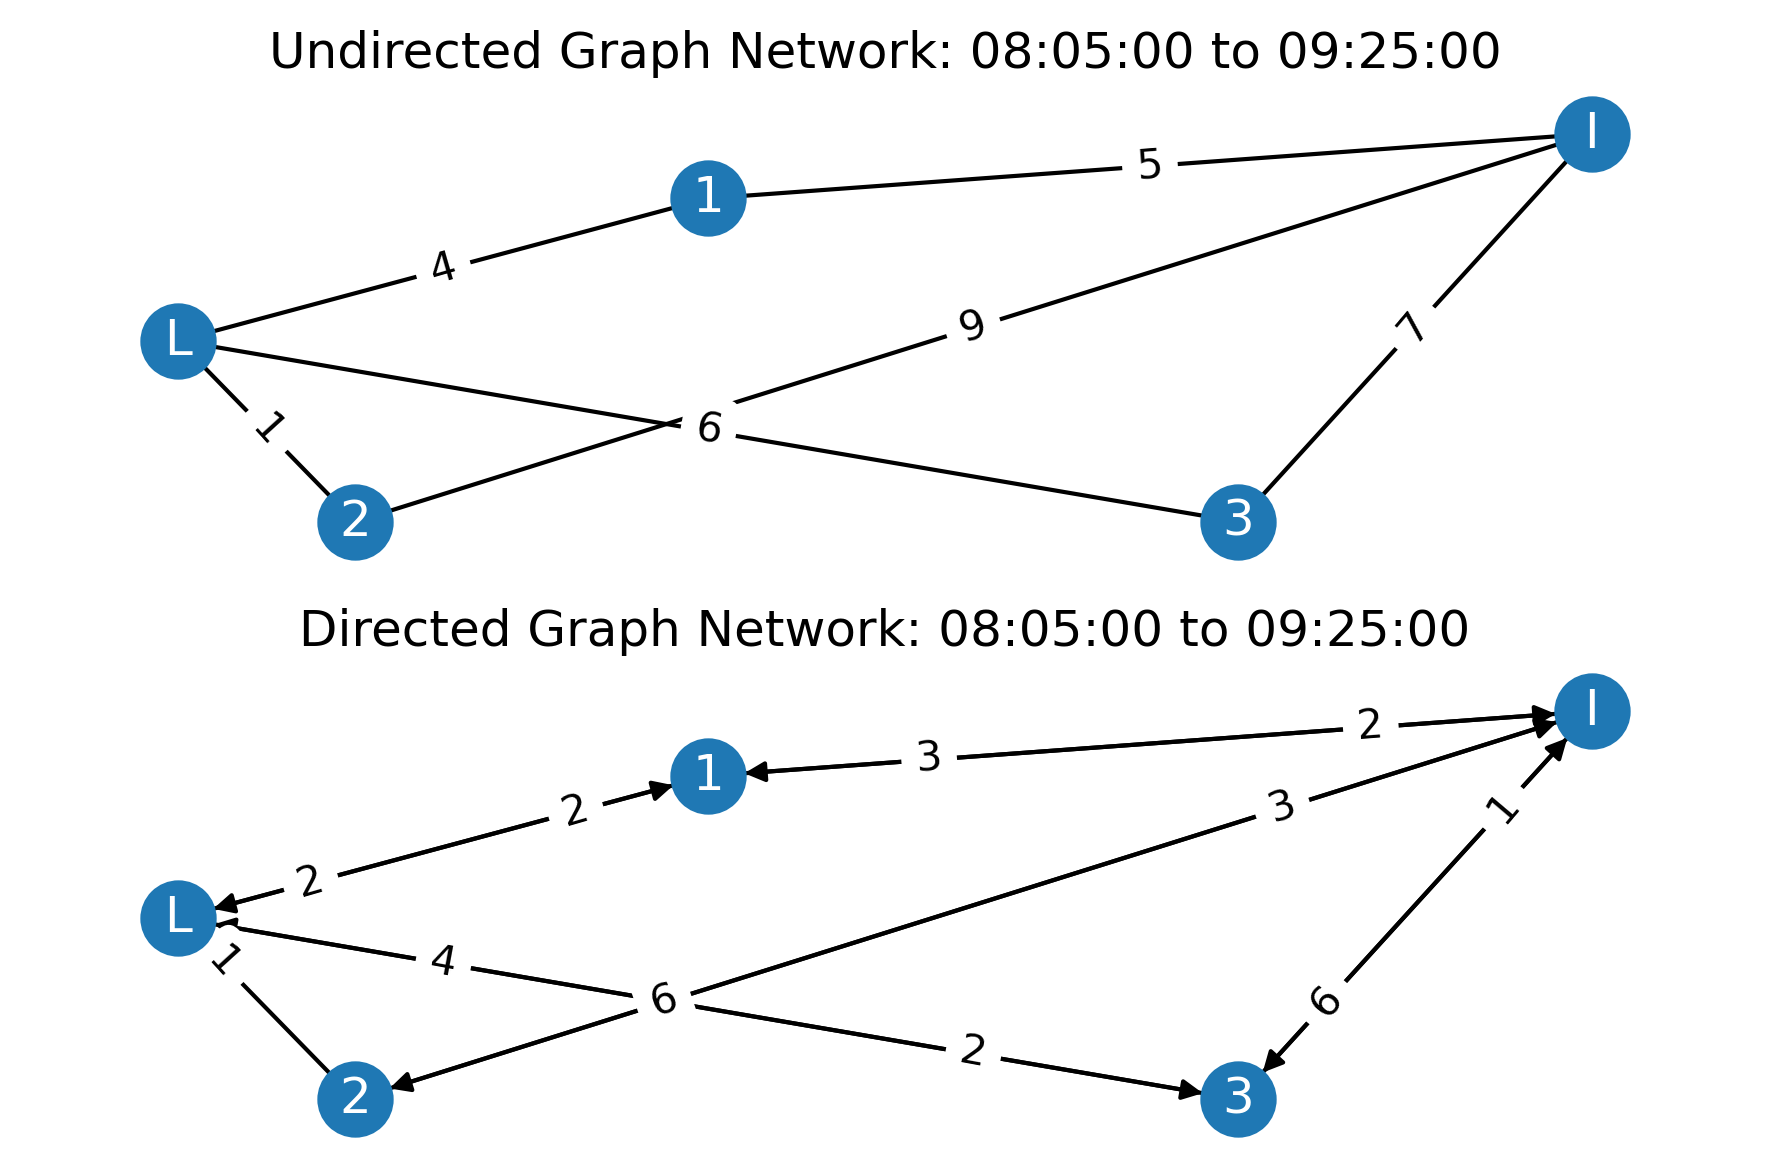

In [9]:
plot_graphs(tu[0])

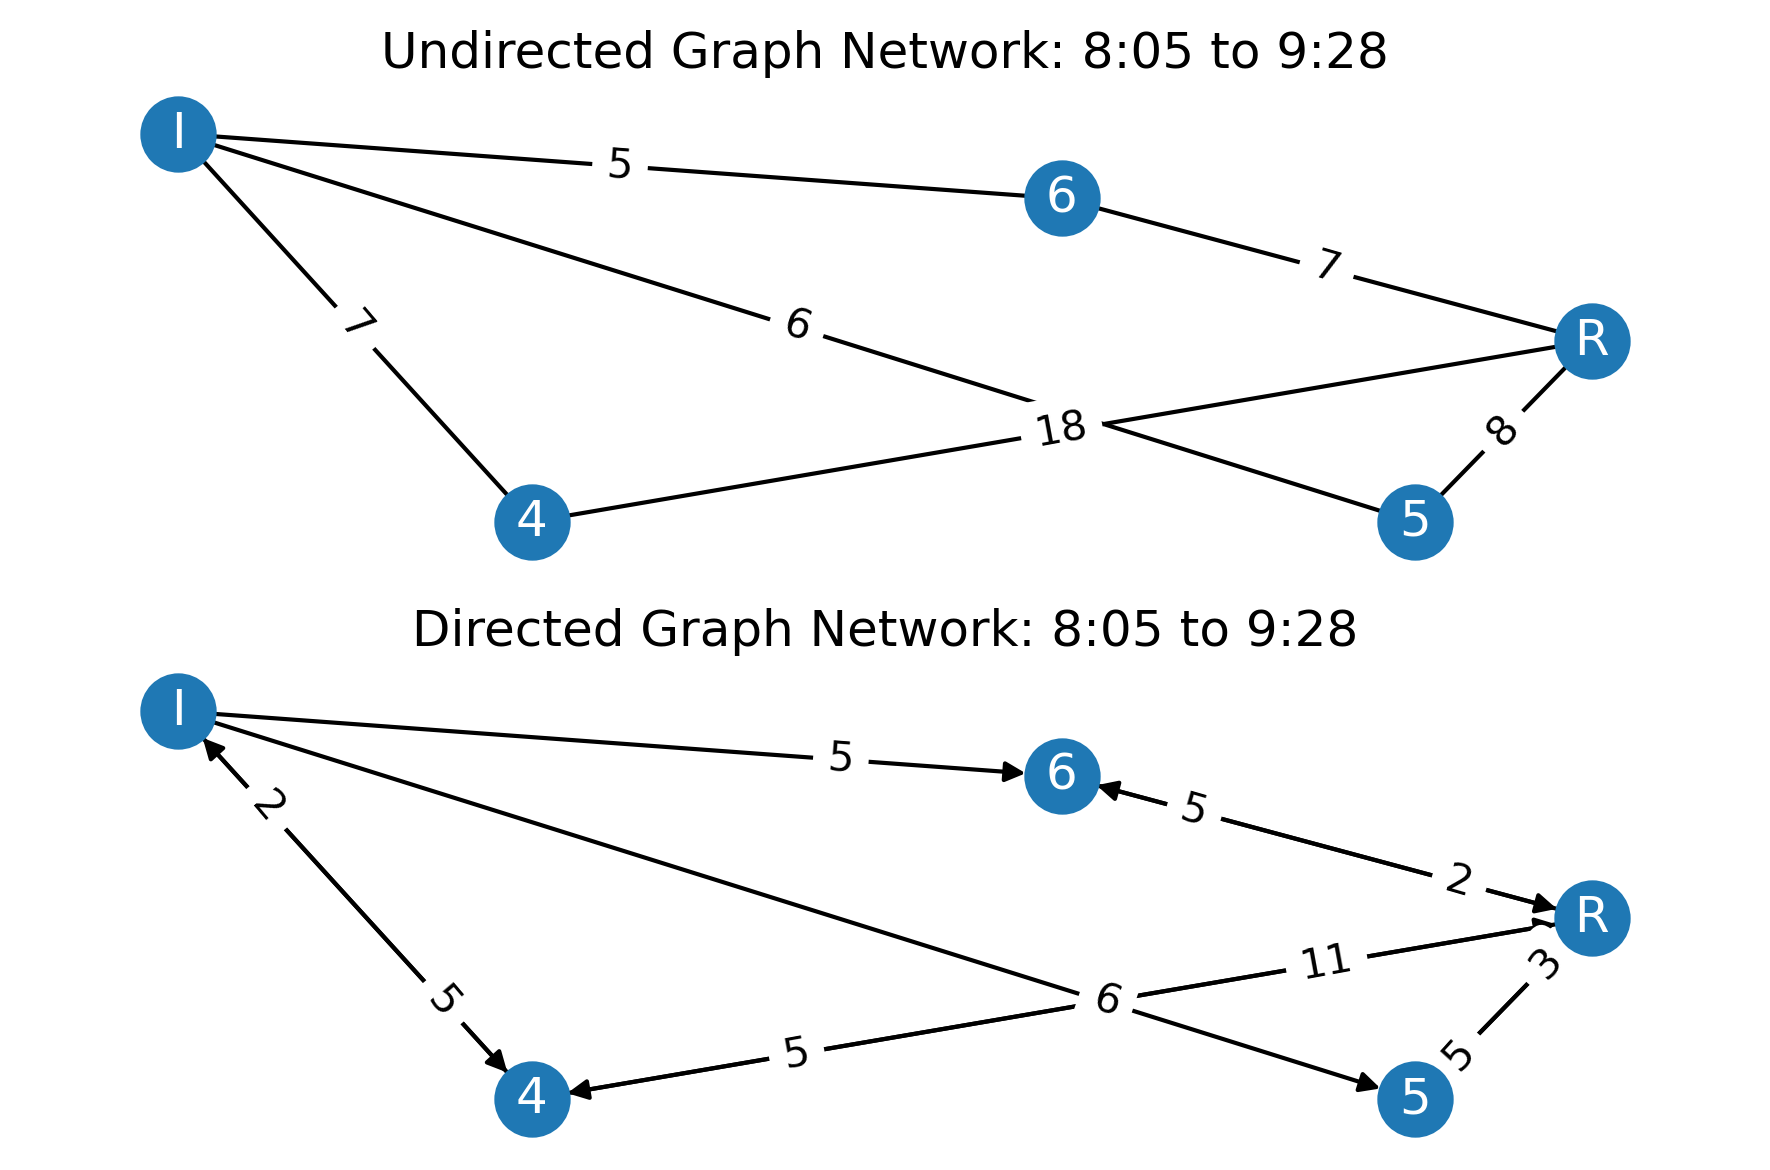

In [10]:
plot_graphs(tu[1])

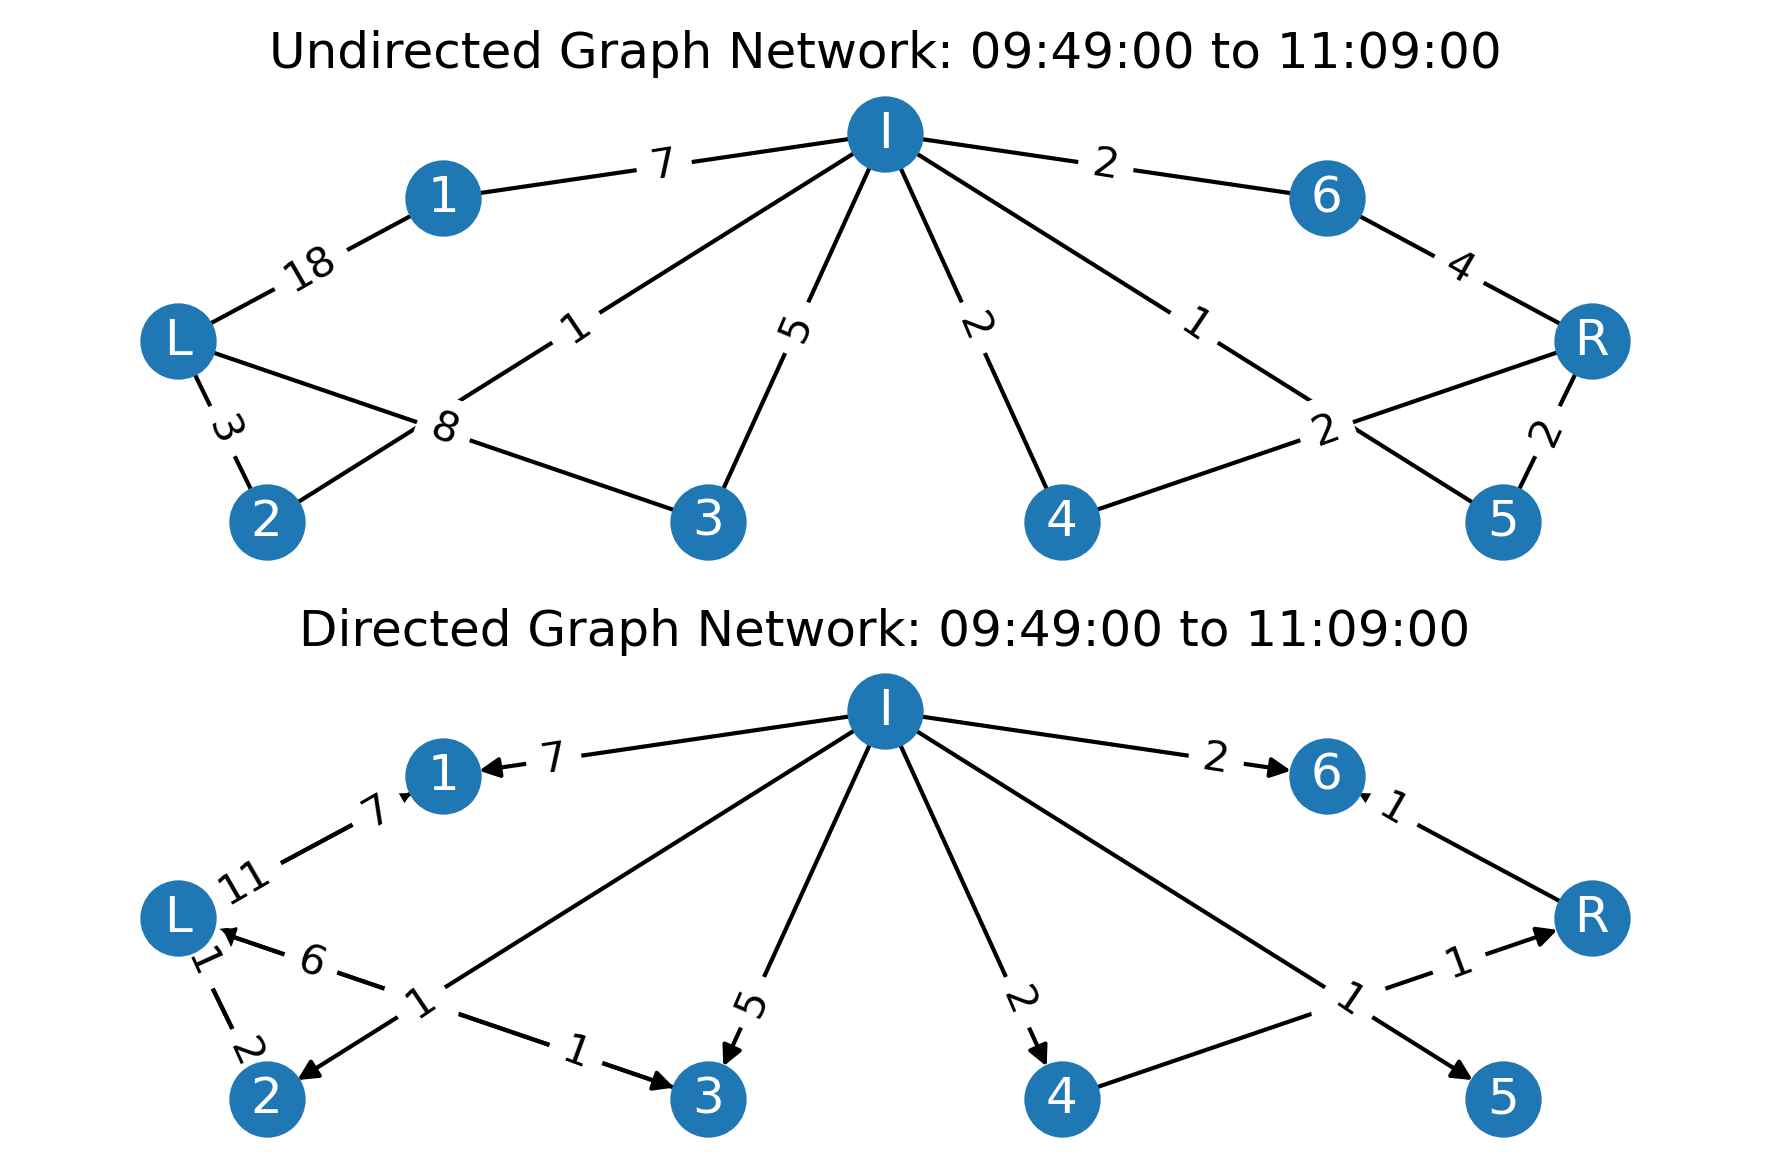

In [11]:
plot_graphs(tu[2])

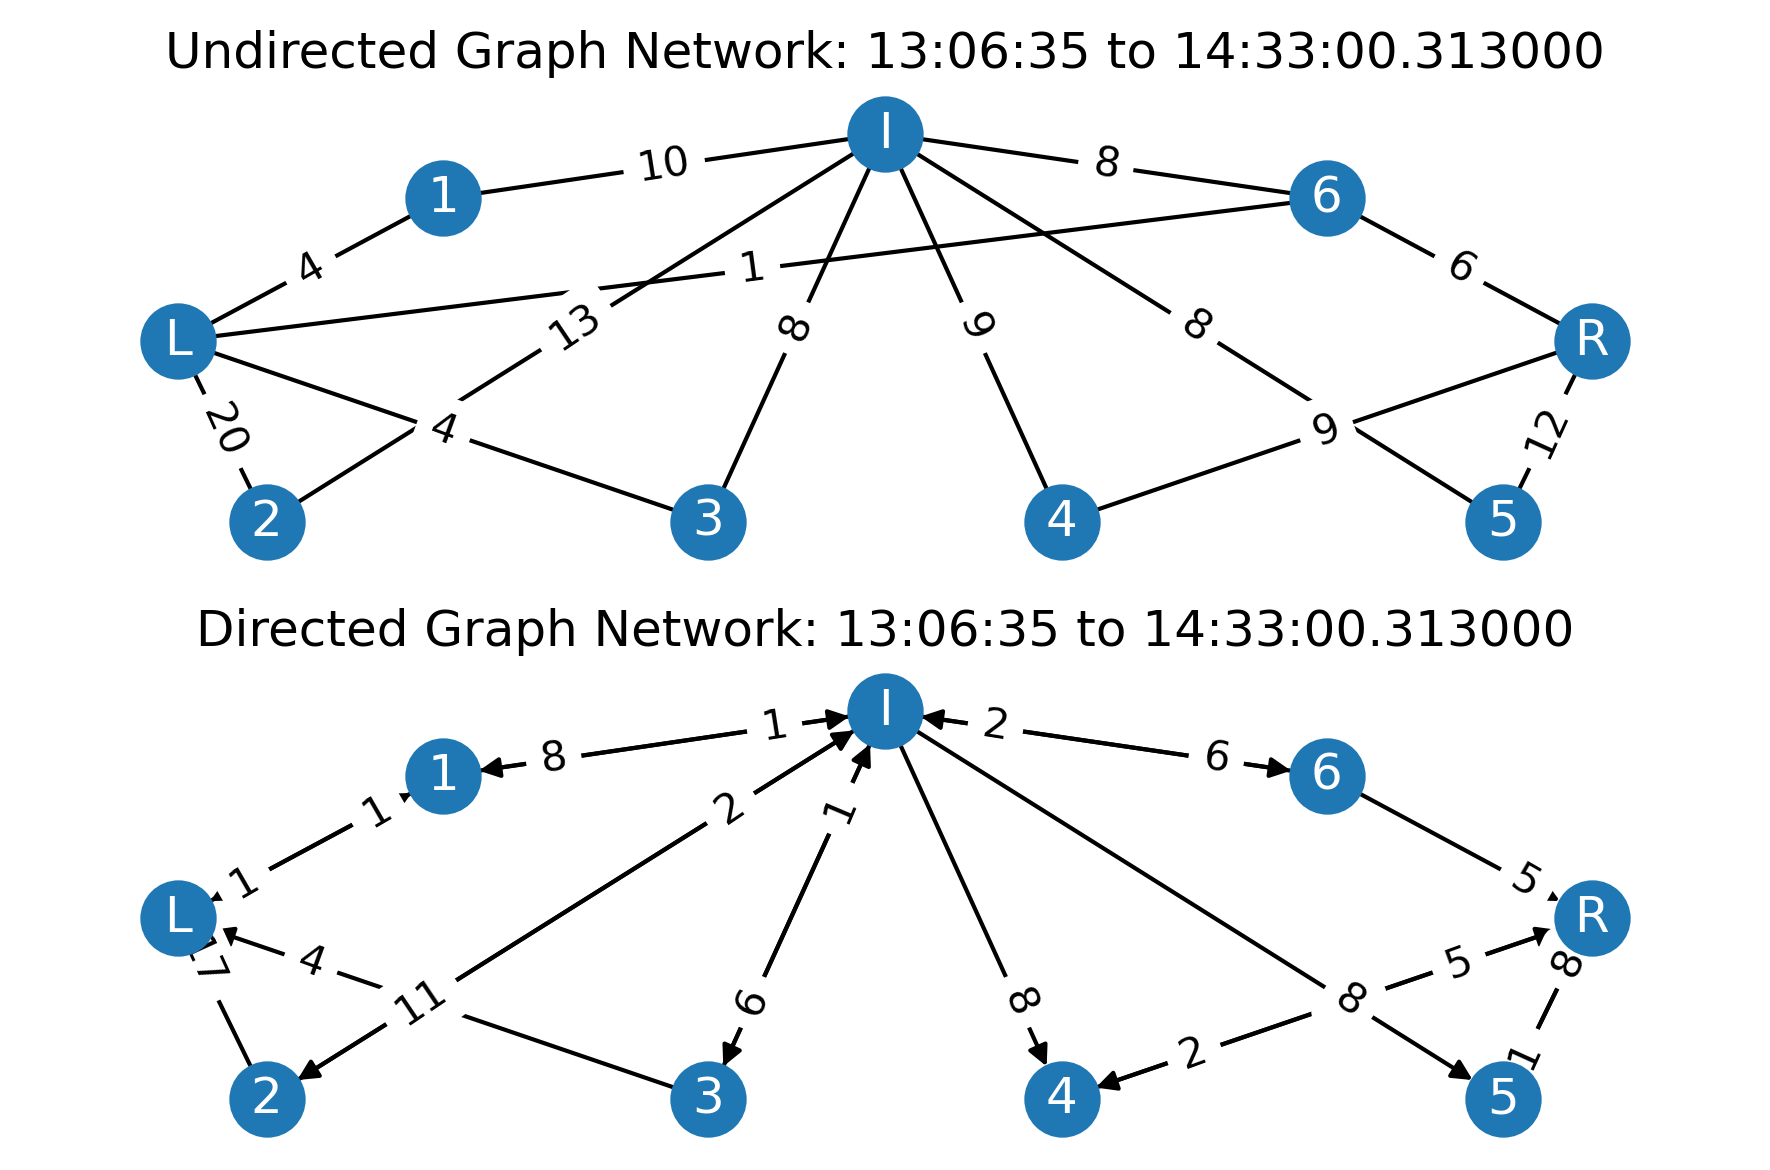

In [12]:
plot_graphs(tu[3])

# Tuesday Analysis

In [46]:
tu = tuesday_data()

In [98]:
def vectorized_split_by_U(dfs):
    # vfunc = np.vectorize(split_by_U, *args)
    # return vfunc(dfs)
    return [split_by_U(df) for df in dfs]

def vectorized_interactions(dfs):
    # vfunc = np.vectorize(interactions, *args)
    # return vfunc(dfs)
    return [interactions(df) for df in dfs]

def vectorized_graphs(dfs):
    # vfunc = np.vectorize(graphs, *args)
    # return vfunc(graphs)
    return [graphs(df) for df in dfs]

def vectorized_plot_graphs(dfs):
    for df in dfs:
        plot_graphs(df)

def split_by_times(df, times, col='t0'):
    """
    Splits `df` by the times
    given in `times`
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to split by times
    times : iterable containing str
        Iterable containing str 
        objects of the times to 
        split by
    col : str, optional
        The name of the time column 
        (default = 't0')
    
    Returns
    -------
    splits : iterable containing pd.DataFrame
        DataFrames of the split data
        
    Notes
    -----
    the split time is inclusive - i.e. 
    times that match the time in `times`
    are included in the first half of the 
    split, not the second half
    """
    splits = [df]
    for time in [pd.Timestamp(t).time() for t in times]:
        temp_df = splits.pop()
        df1 = temp_df.loc[np.where(temp_df[col] <= time)].reset_index(drop=True)
        df2 = temp_df.loc[np.where(~(temp_df[col] <= time))].reset_index(drop=True)
        splits.append(df1)
        splits.append(df2)
    return splits

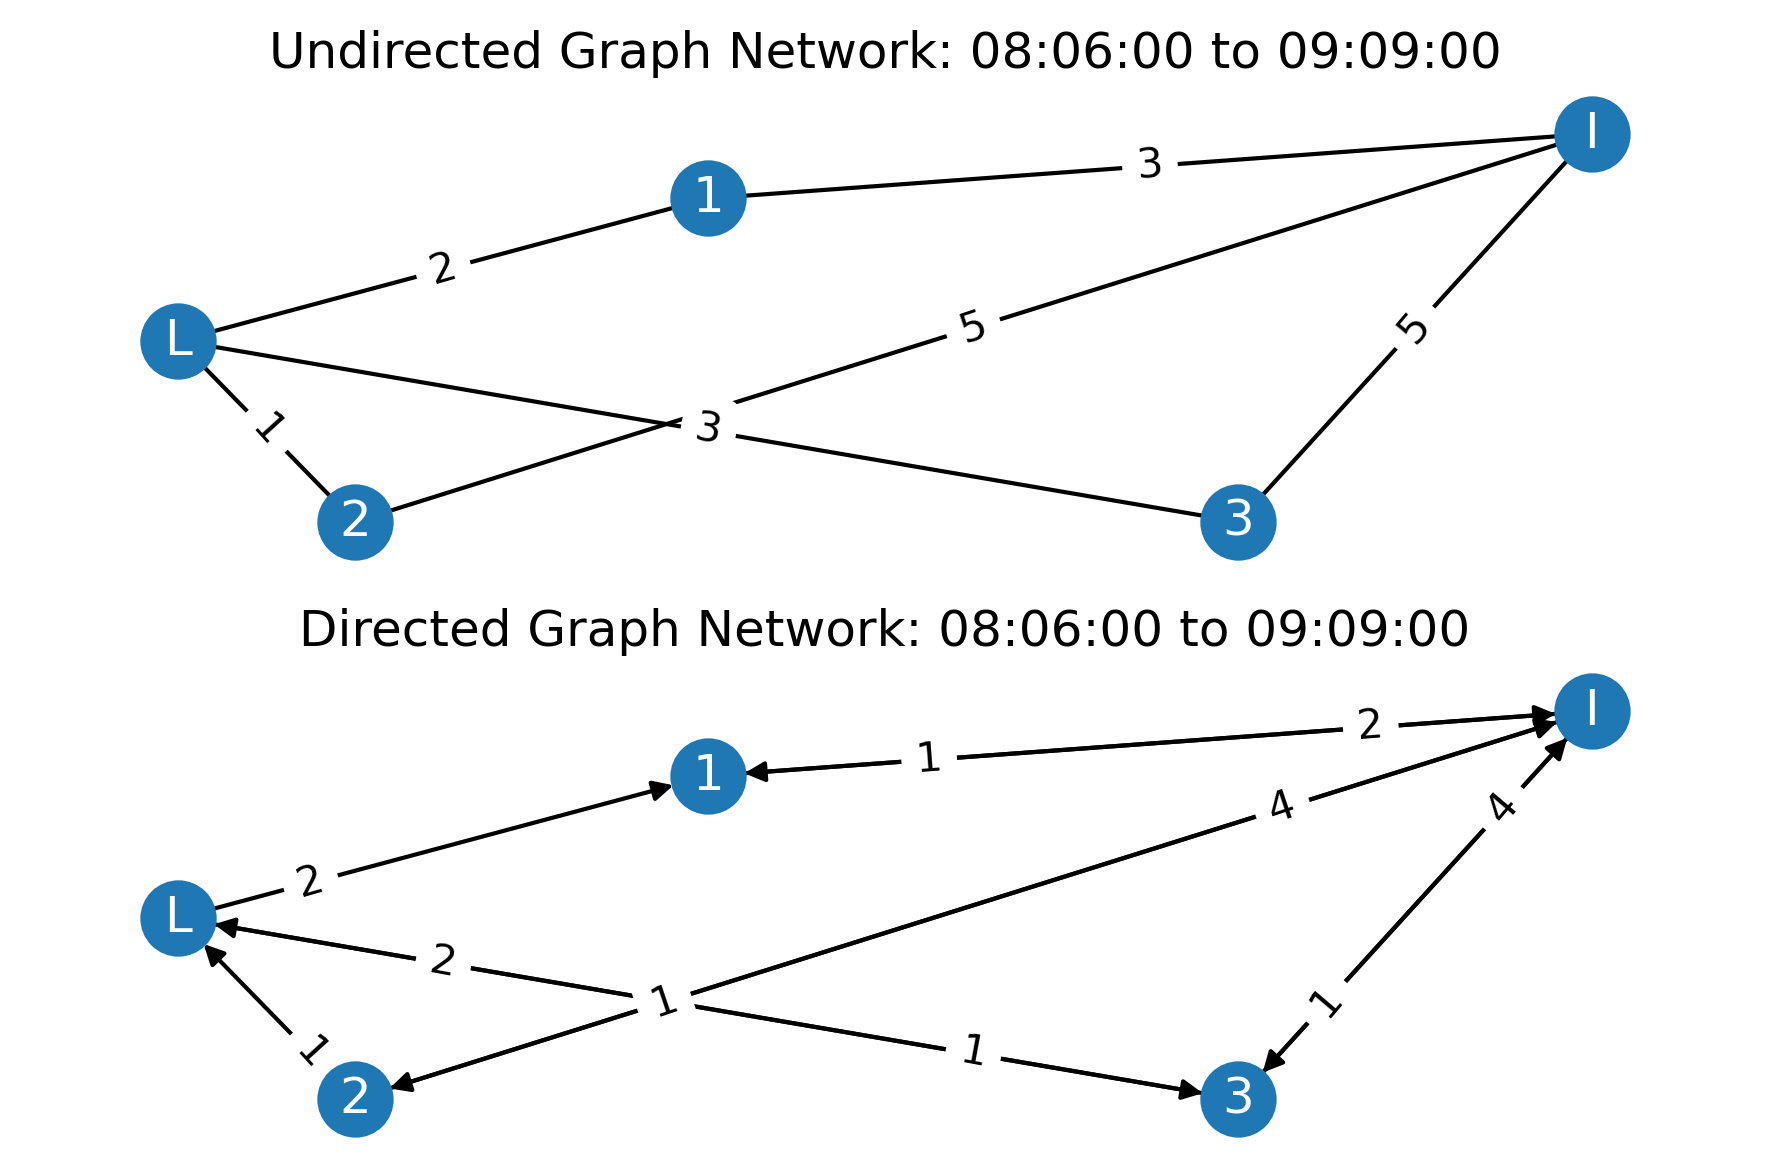

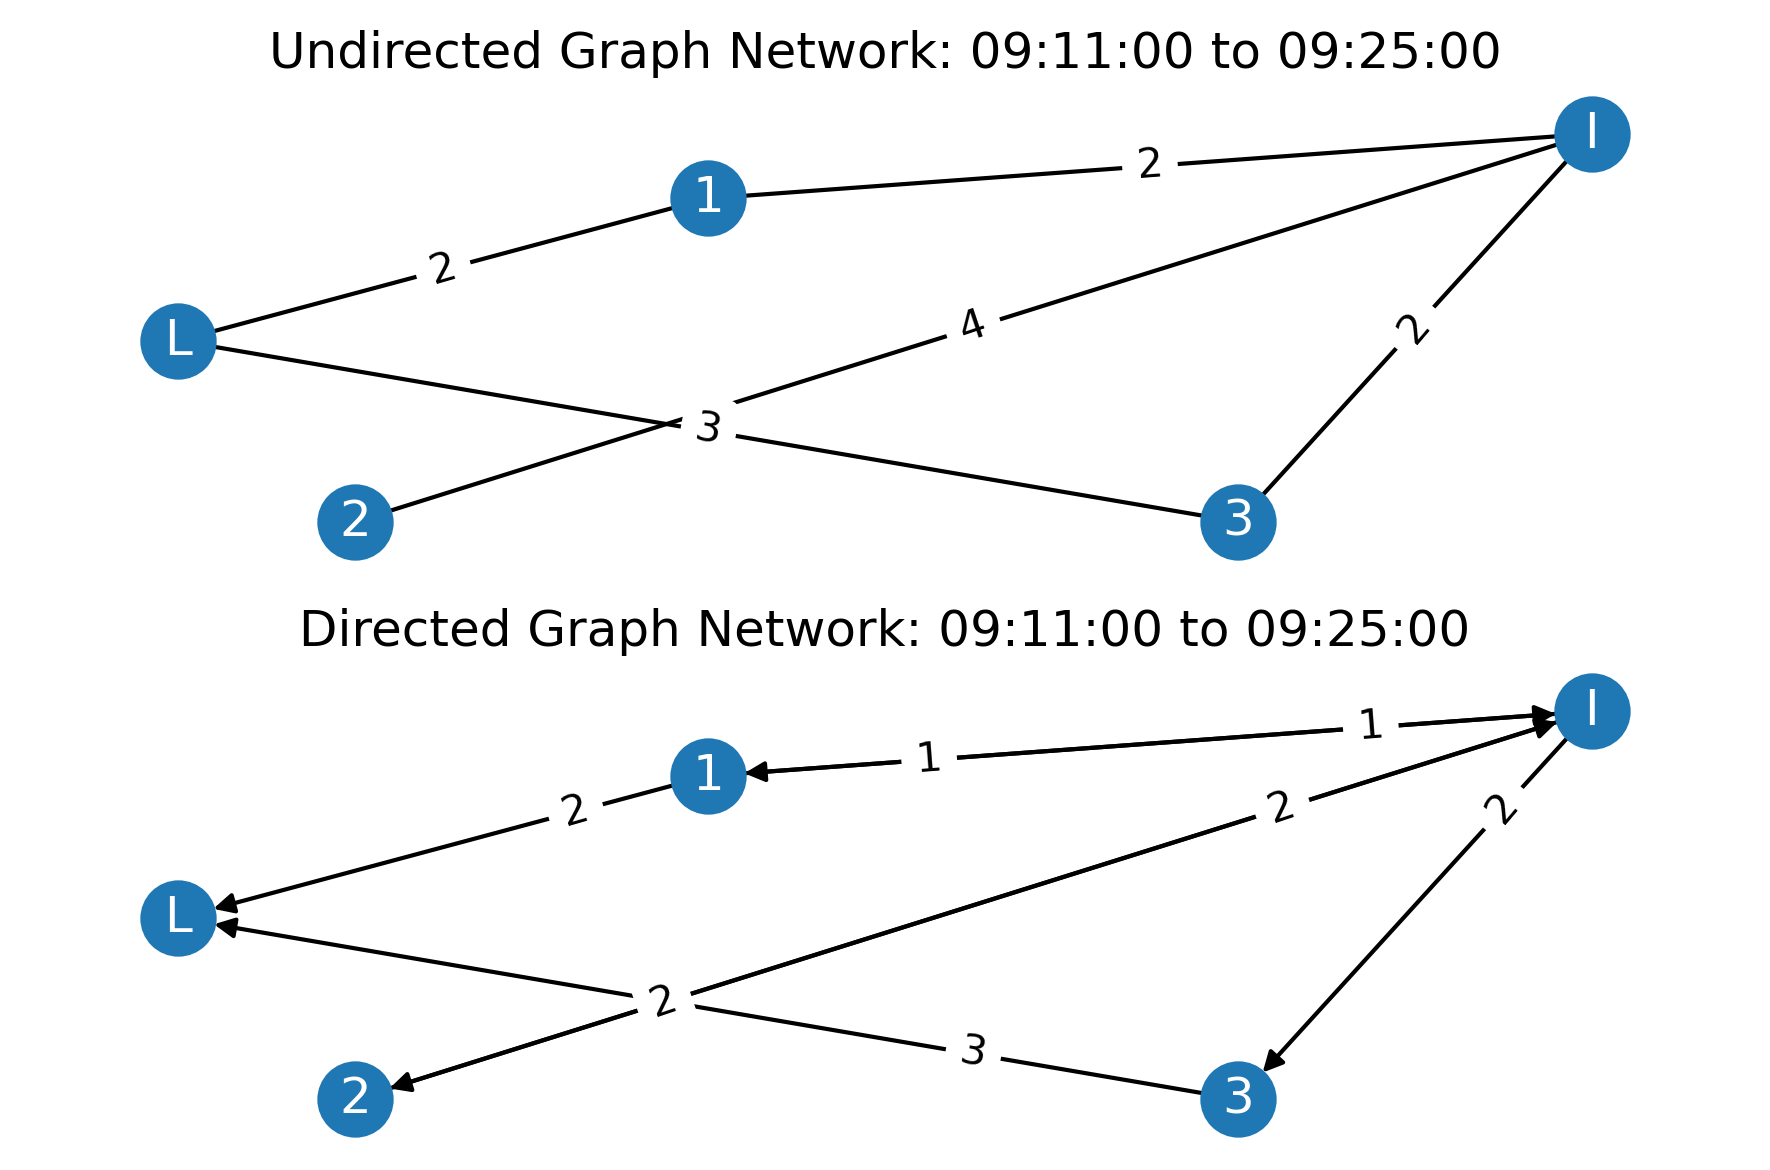

In [33]:
vectorized_plot_graphs(split_by_times(tu[0], ['9:00:00']))

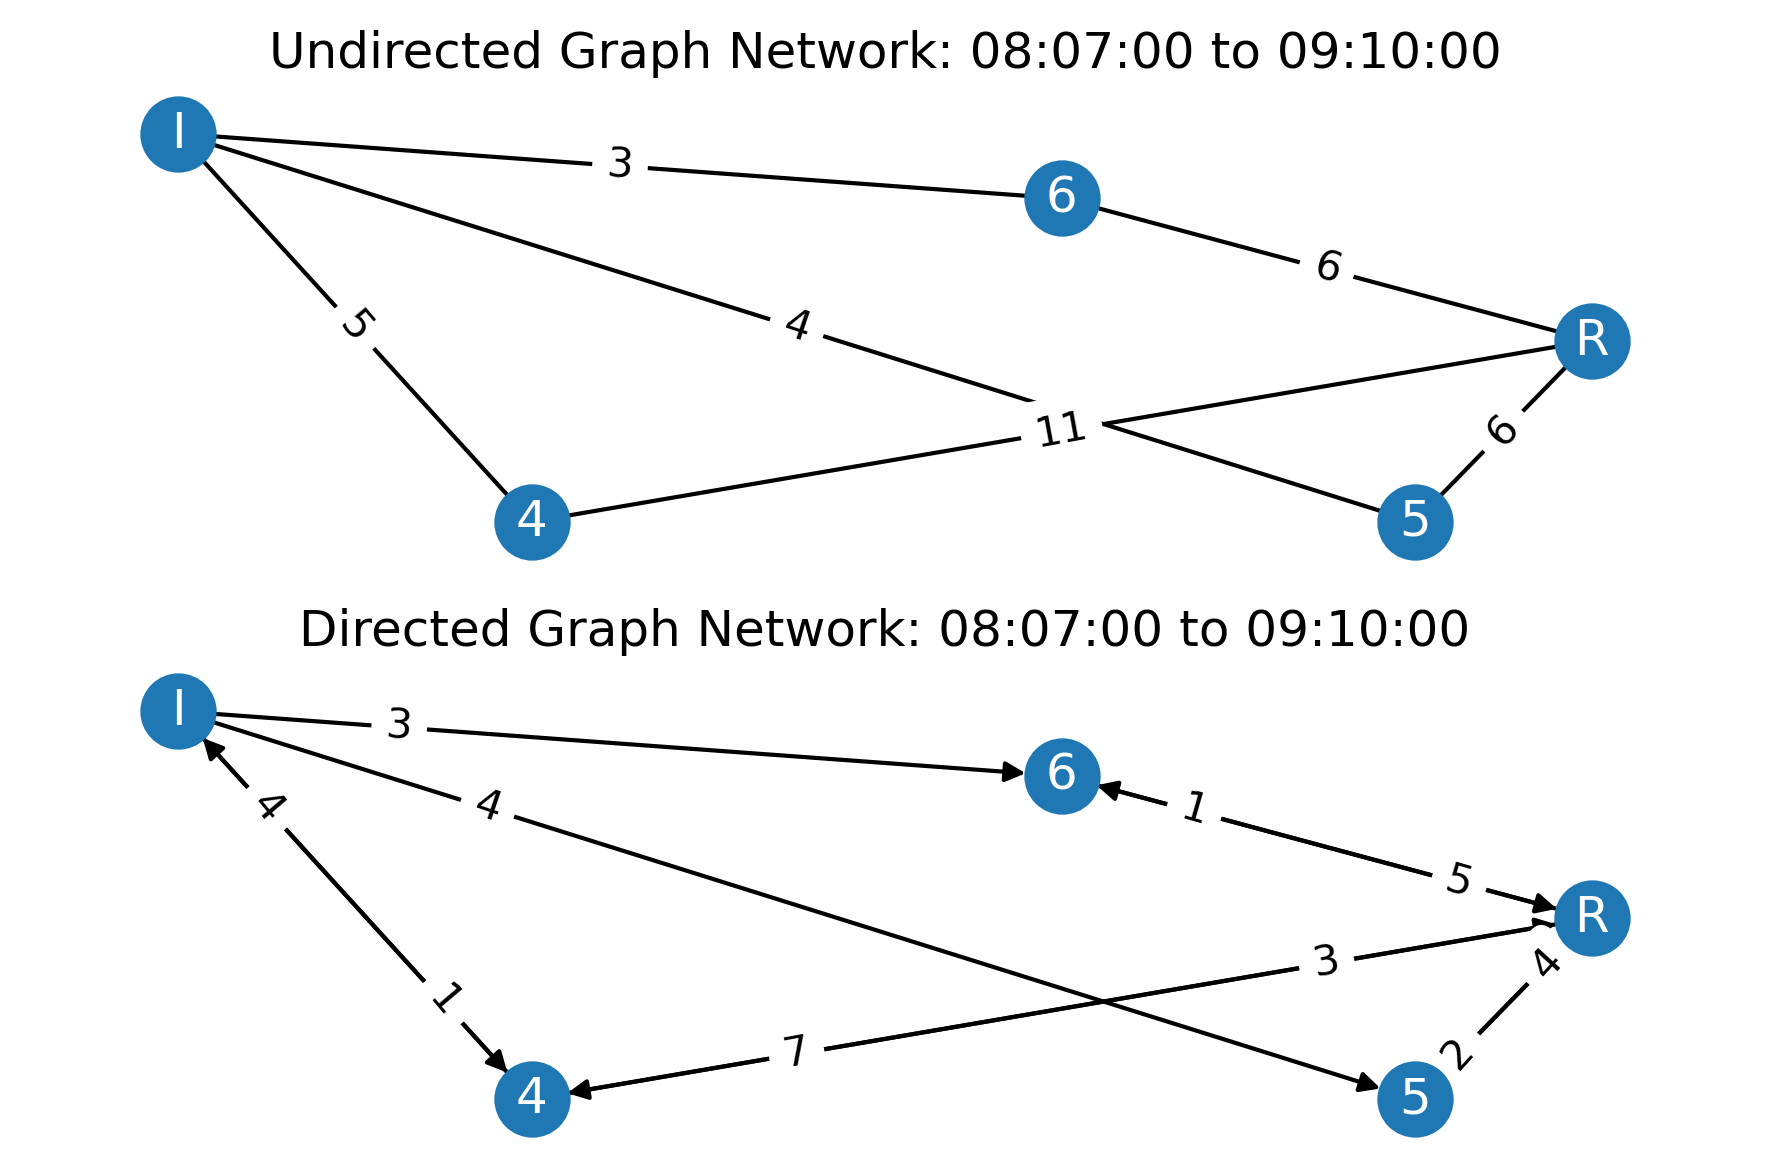

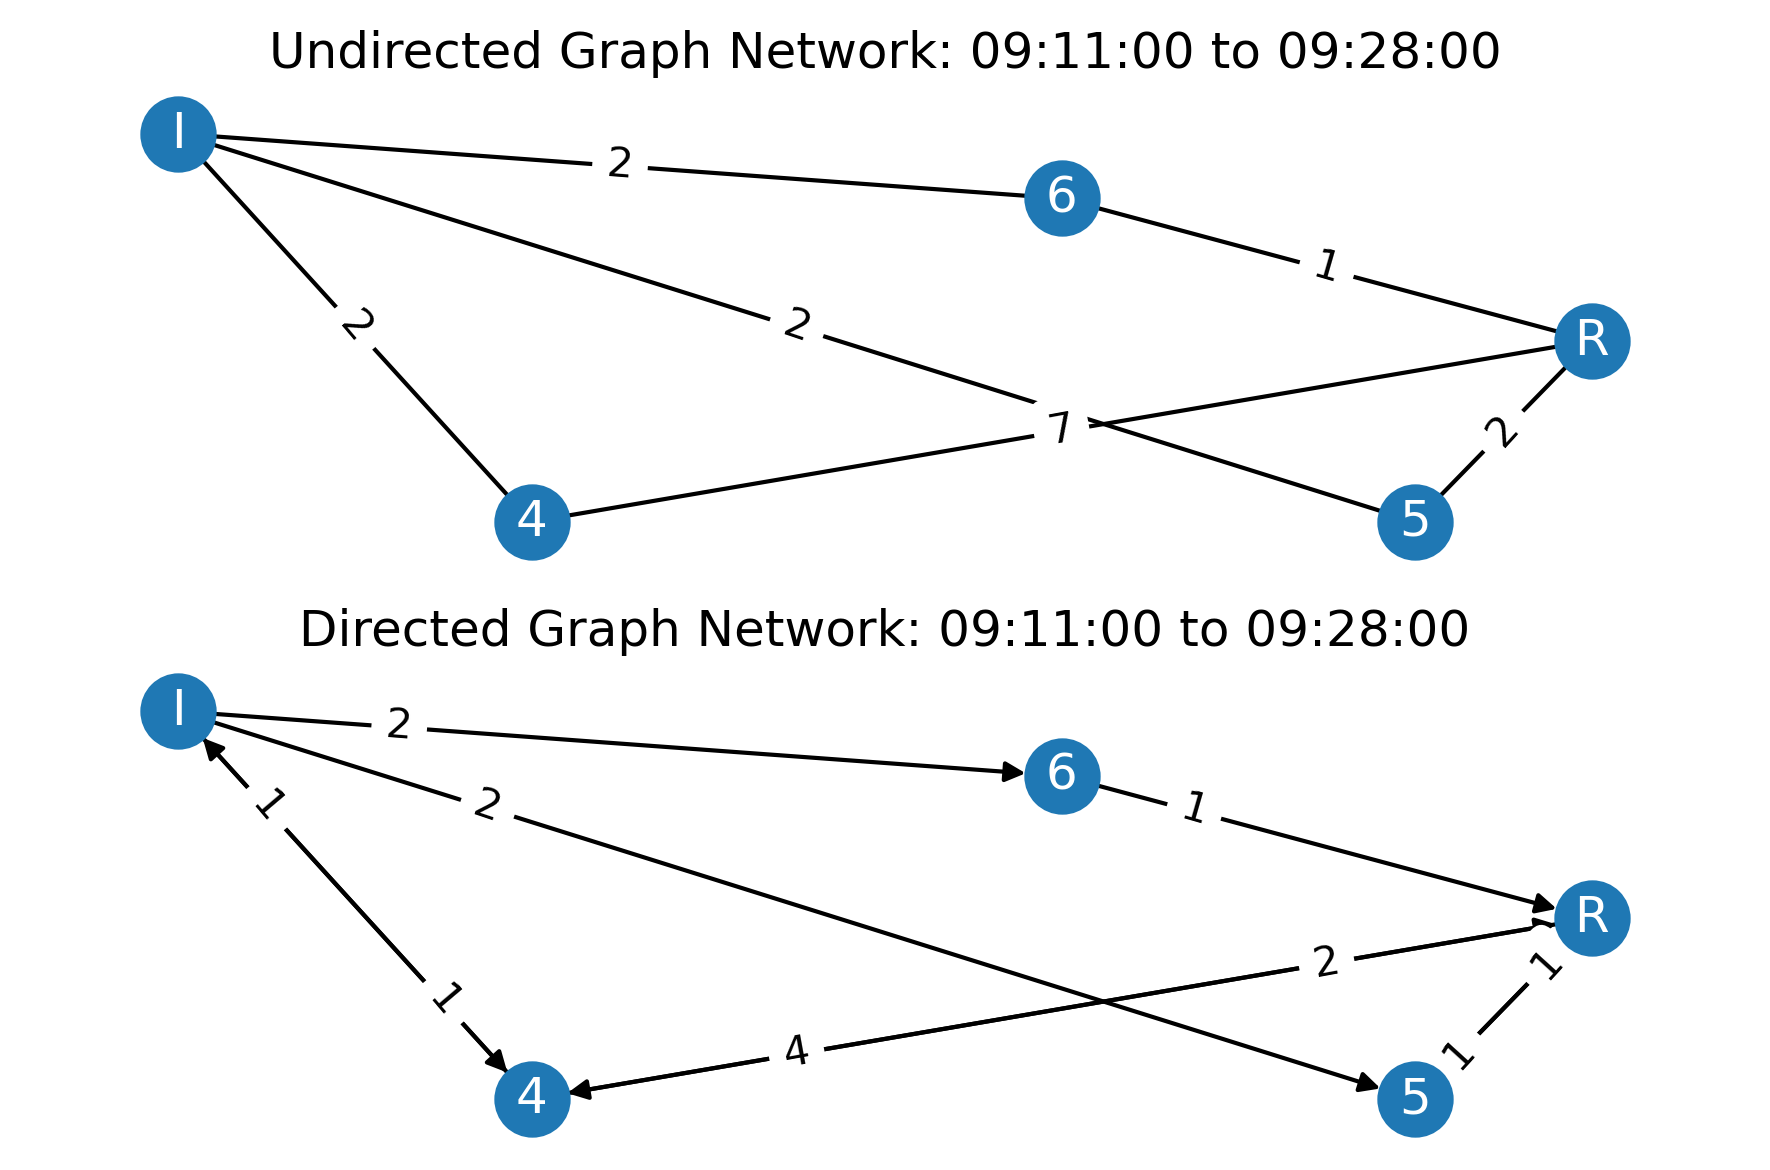

In [34]:
vectorized_plot_graphs(split_by_times(tu[1], ['9:10:00'], col='t'))

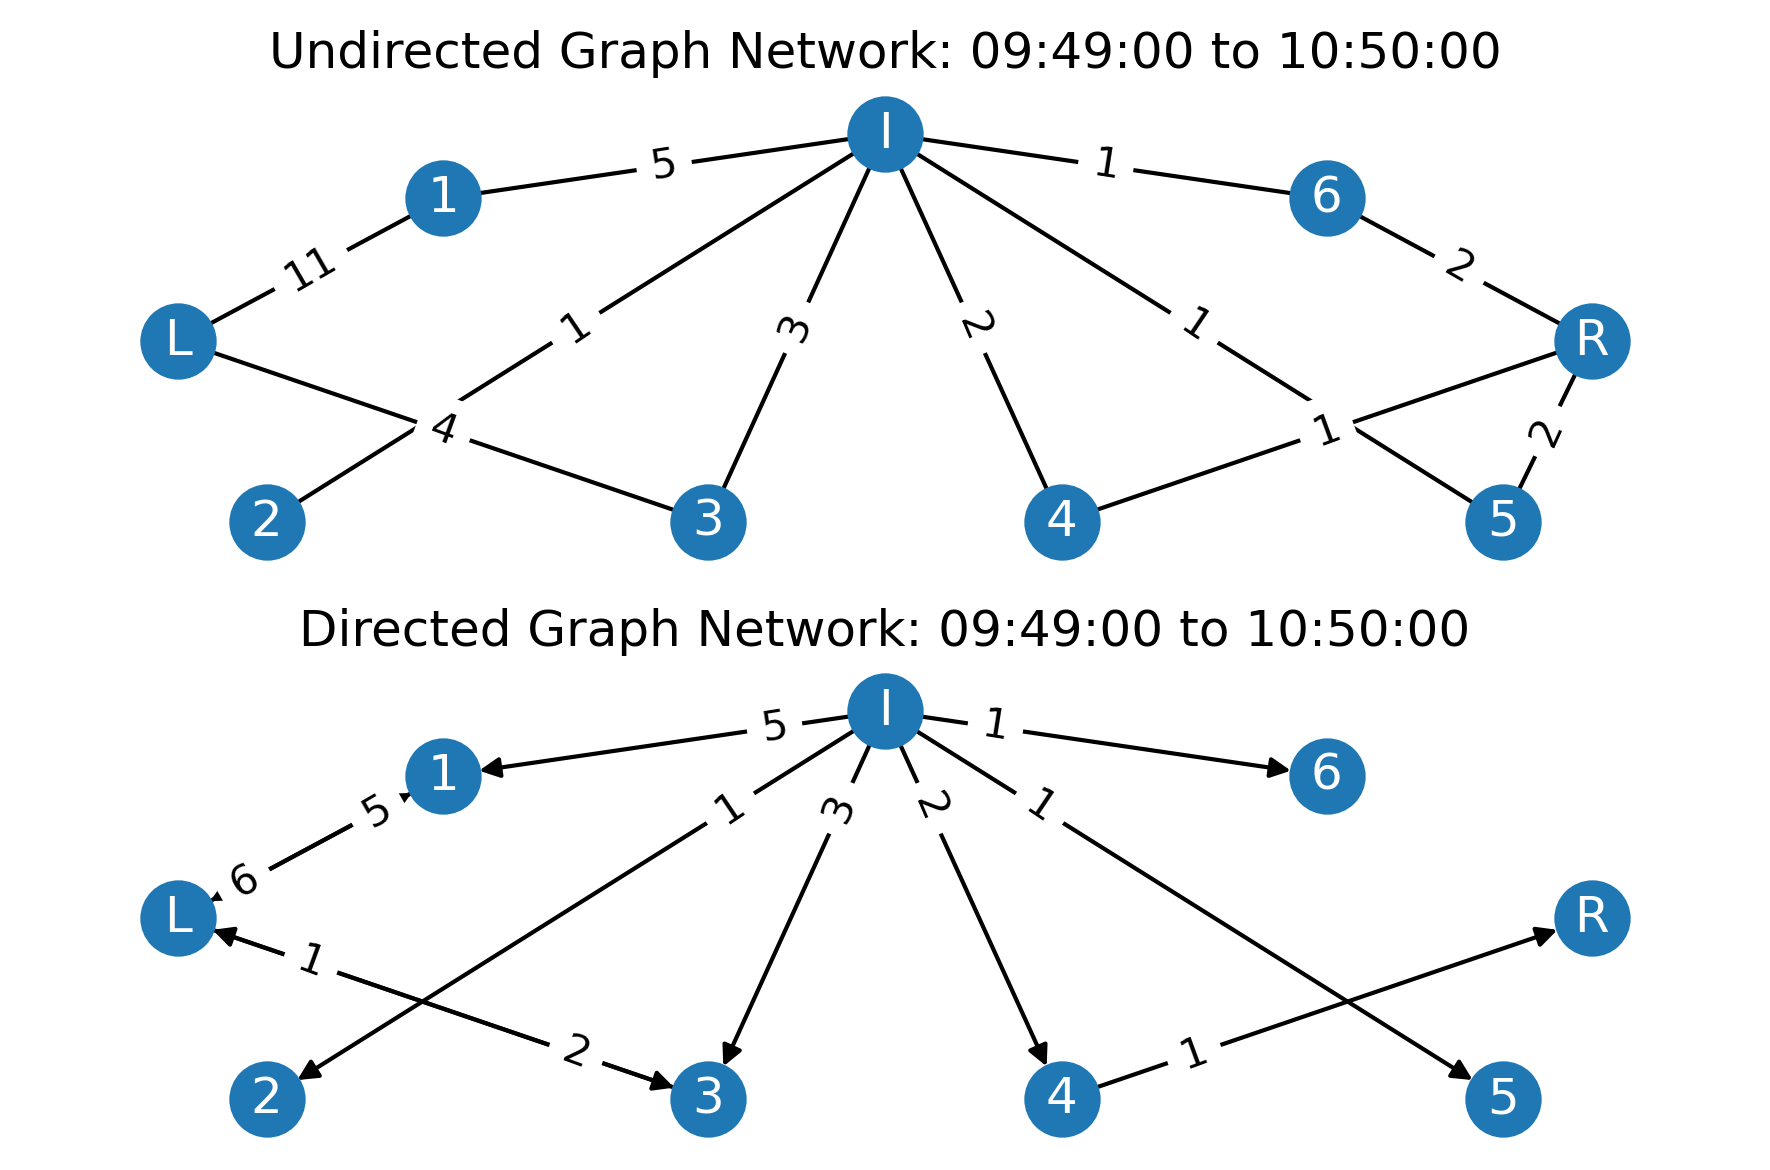

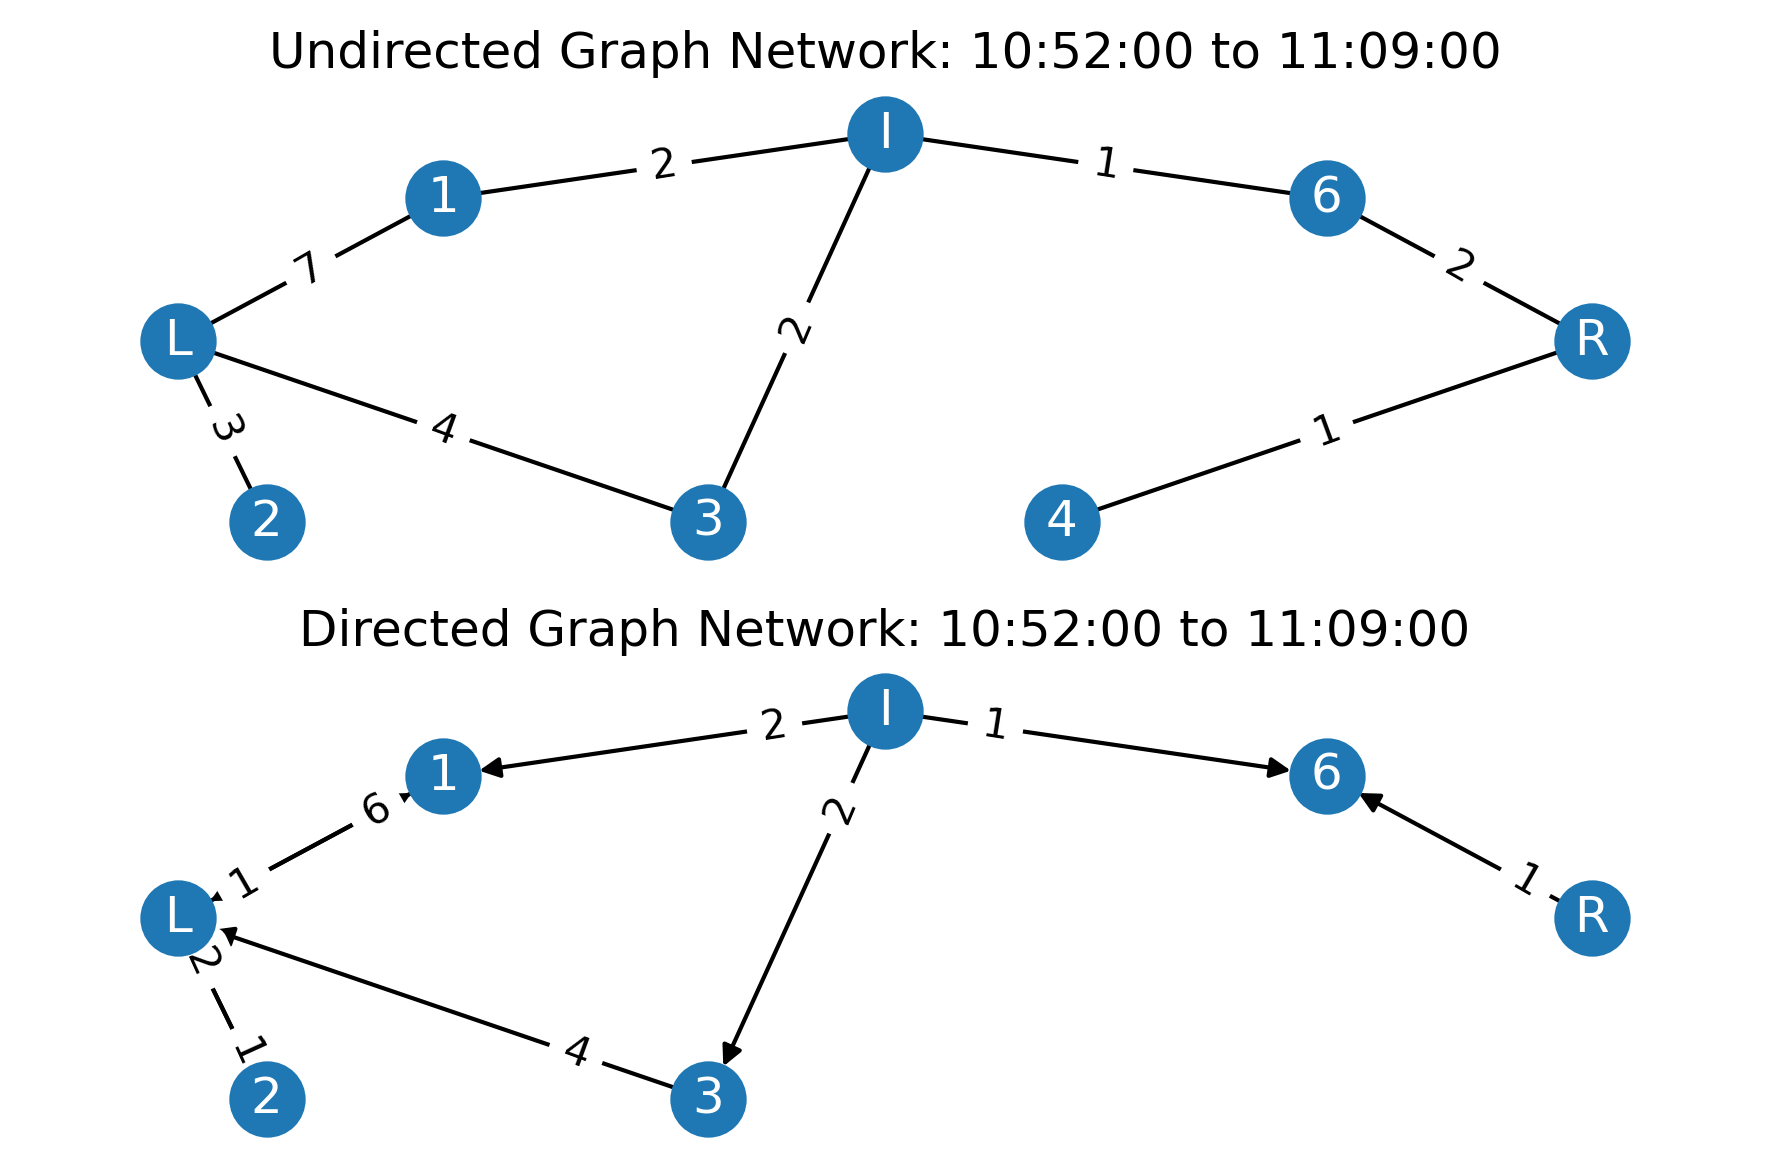

In [52]:
vectorized_plot_graphs(split_by_times(tu[2], ['10:51:00'], col='t'))

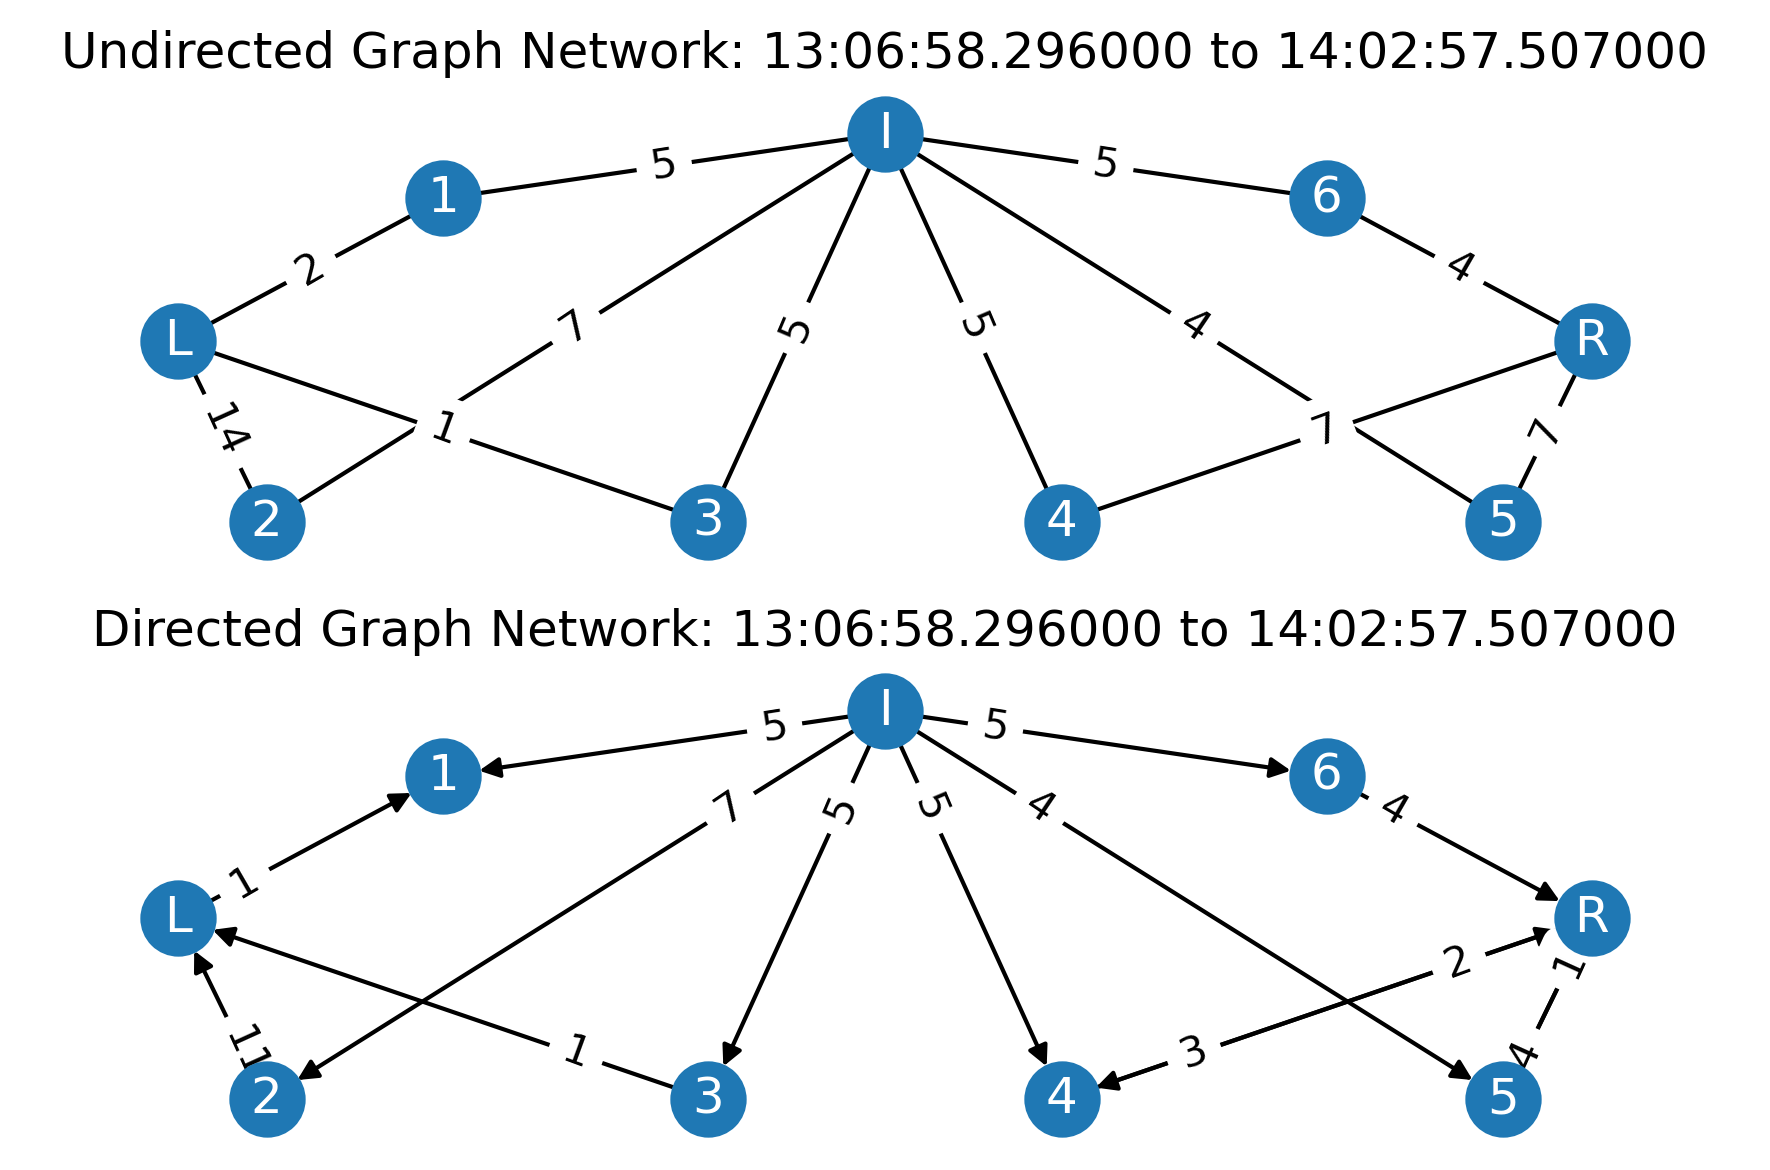

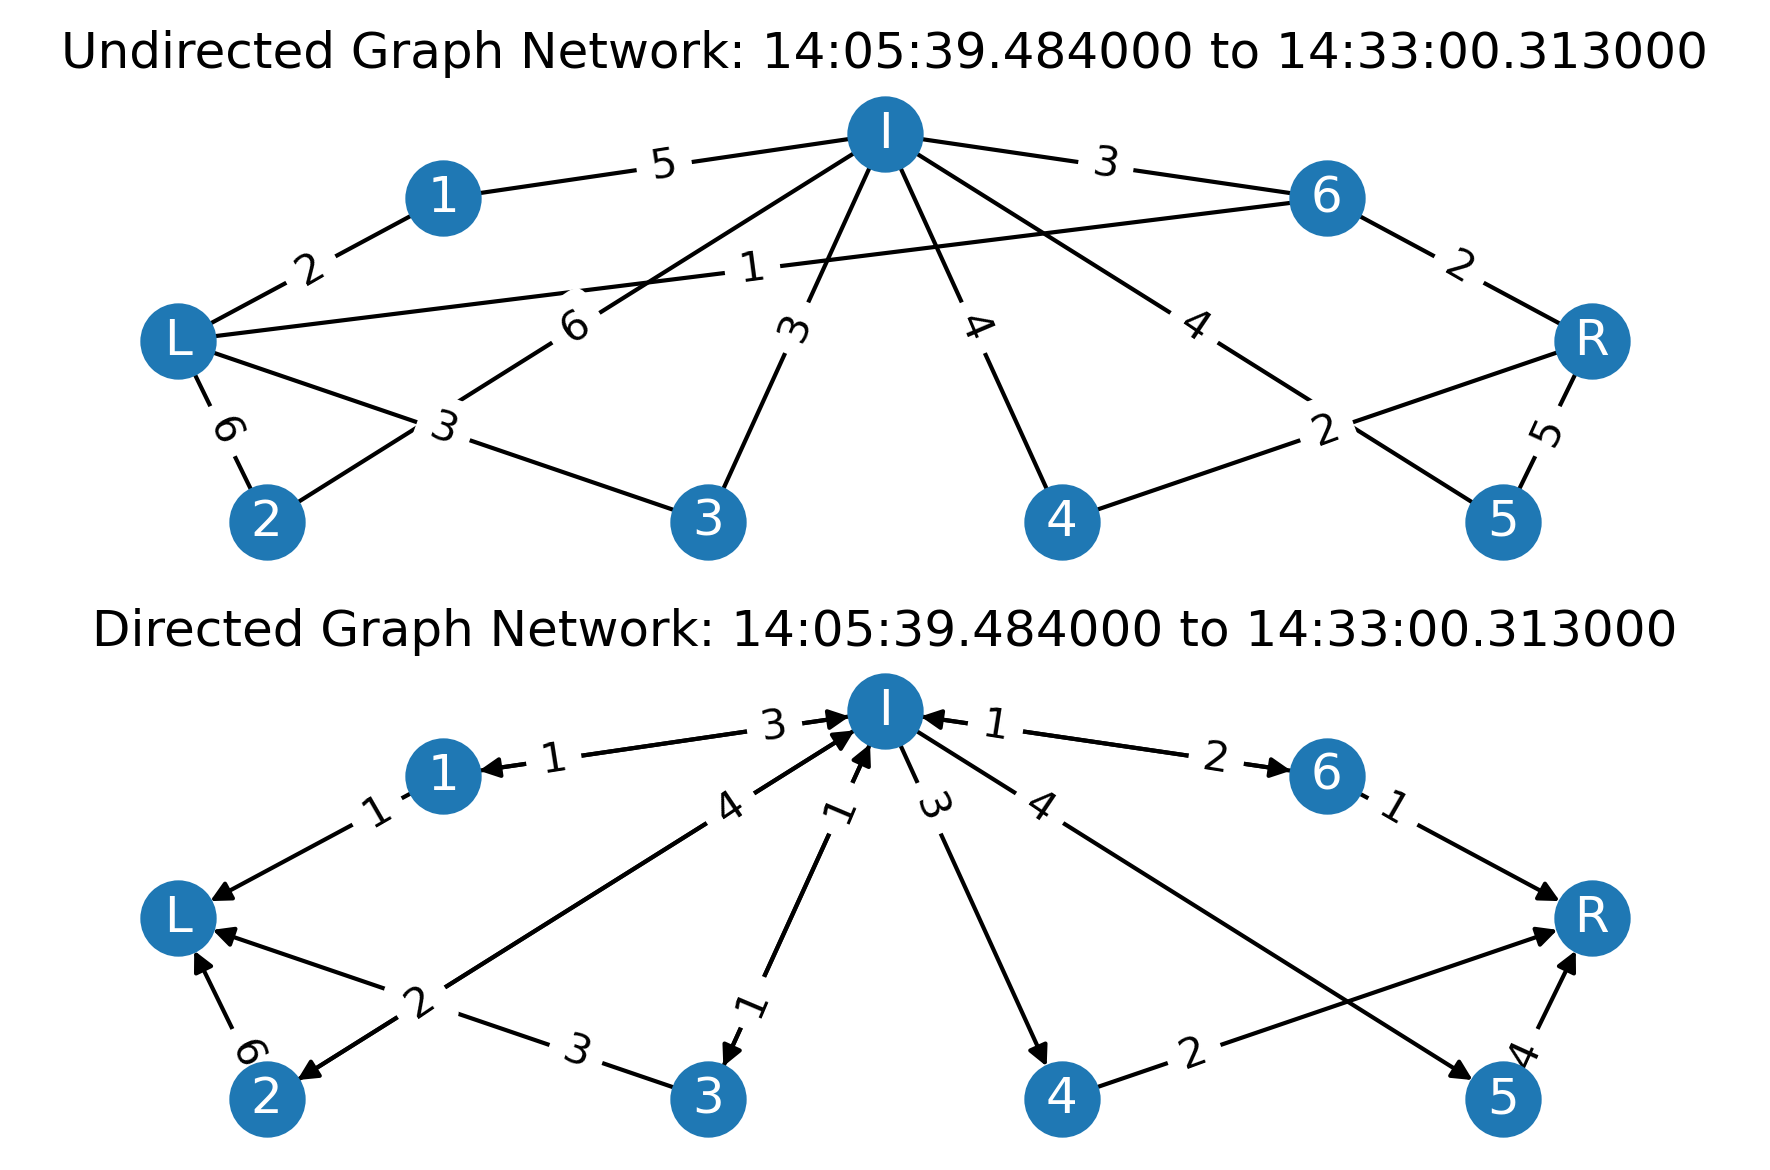

In [50]:
vectorized_plot_graphs(split_by_times(tu[3], ['14:03:00'], col='t'))

## Comparing Networks Before and During Group Assignment

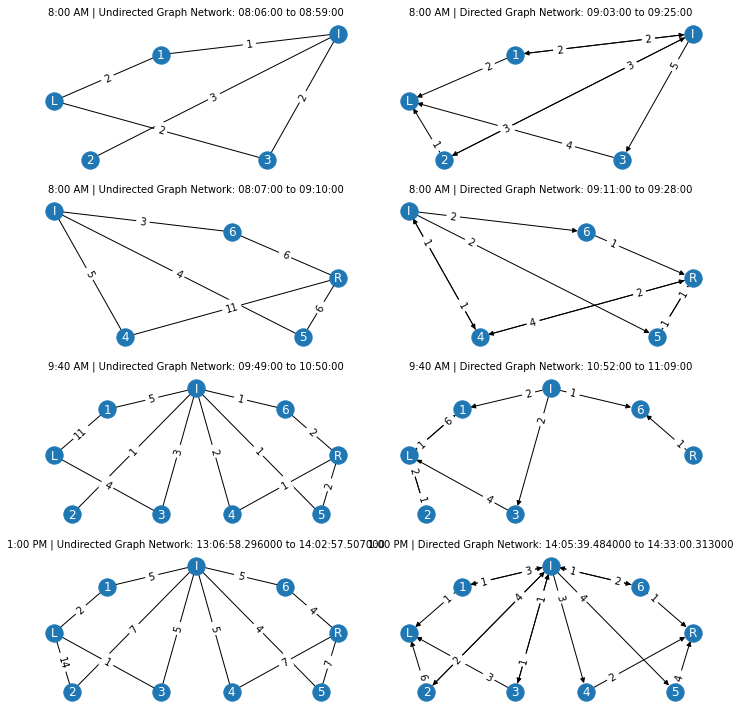

In [84]:
tu = tuesday_data()
s0a, s0b = split_by_times(tu[0], ['9:00:00'], col='t')
s1a, s1b = split_by_times(tu[1], ['9:10:00'], col='t')
s2a, s2b = split_by_times(tu[2], ['10:51:00'], col='t')
s3a, s3b = split_by_times(tu[3], ['14:03:00'], col='t')

fig, ax = plt.subplots(4, 2, layout='tight', figsize=(10,10))

plot_undirected_graph(s0a, ax=ax[0,0], added_text='8:00 AM')
plot_undirected_graph(s1a, ax=ax[1,0], added_text='8:00 AM')#, clear_title=True)
plot_undirected_graph(s2a, ax=ax[2,0], added_text='9:40 AM')#, clear_title=True)
plot_undirected_graph(s3a, ax=ax[3,0], added_text='1:00 PM')#, clear_title=True)

plot_directed_graph(s0b, ax=ax[0,1], added_text='8:00 AM')
plot_directed_graph(s1b, ax=ax[1,1], added_text='8:00 AM')#, clear_title=True)
plot_directed_graph(s2b, ax=ax[2,1], added_text='9:40 AM')#, clear_title=True)
plot_directed_graph(s3b, ax=ax[3,1], added_text='1:00 PM')#, clear_title=True)

plt.savefig("before_during_group_assignment.png", dpi=300, bbox_inches='tight')

## 10 minute Average Networks Before and During Group Assignment

In [85]:
tu = tuesday_data()
s0a, s0b = split_by_times(tu[0], ['9:00:00'], col='t')
s1a, s1b = split_by_times(tu[1], ['9:10:00'], col='t')
s2a, s2b = split_by_times(tu[2], ['10:51:00'], col='t')
s3a, s3b = split_by_times(tu[3], ['14:03:00'], col='t')

In [137]:
avg_N_interactions = {
    '8:00AM_1_PRE':[],
    '8:00AM_1_GA':[],
    '8:00AM_2_PRE':[],
    '8:00AM_2_GA':[],
    '9:40AM_PRE':[],
    '9:40AM_GA':[],
    '1:00PM_PRE':[],
    '1:00PM_GA':[]
}
splits = [(s0a,s0b),
          (s1a,s1b),
          (s2a,s2b),
          (s3a,s3b)]
keys = list(avg_N_interactions.keys())
tbreaks = [(('8:10:00', '9:00:00'), ('9:10:00', '9:30:00')),
           (('8:10:00', '9:00:00'), ('9:10:00', '9:30:00')),
           (('9:51:00', '10:51:00'),('11:01:00','11:20:00')),
           (('13:13:00','14:03:00'),('14:13:00','14:30:00'))]
for i in range(4):
    j = 2*i
    df1, df2 = splits[i]
    tspan1, tspan2 = tbreaks[i]
    tstart1, tstop1 = tspan1
    tstart2, tstop2 = tspan2
    tsplit1 = split_by_times(
        df1.reset_index(drop=True),
        [str(x) for x in pd.date_range(start=tstart1, end=tstop1, freq='10Min').time],
        col='t')
    avg1 = np.mean([u['counts'].sum() for u, d in [interactions(df) for df in tsplit1]])
    avg_N_interactions[keys[j]].append(avg1)
    tsplit2 = split_by_times(
        df2.reset_index(drop=True),
        [str(x) for x in pd.date_range(start=tstart2, end=tstop2, freq='10Min').time],
        col='t')
    avg2 = np.mean([u['counts'].sum() for u, d in [interactions(df) for df in tsplit2]])
    avg_N_interactions[keys[j+1]].append(avg2)
avg_N_interactions10min = pd.DataFrame(avg_N_interactions)
avg_N_interactions10min

,8:00AM_1_PRE,8:00AM_1_GA,8:00AM_2_PRE,8:00AM_2_GA,9:40AM_PRE,9:40AM_GA,1:00PM_PRE,1:00PM_GA
0,1.428571,5.5,5.0,4.0,4.125,7.333333,9.428571,15.333333


<Figure size 432x288 with 0 Axes>

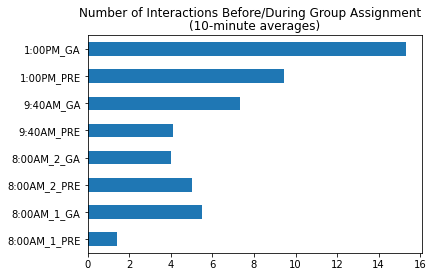

In [155]:
fig = plt.figure()
avg_N_interactions10min.T.rename(columns={0:'N interactions (10-minute average)'}).plot.barh()
# plt.xticks(rotation=60)
plt.gca().get_legend().remove()
plt.suptitle("Number of Interactions Before/During Group Assignment")
plt.title("(10-minute averages)")
plt.savefig("10minute-averaged-interactions.png", dpi=300, bbox_inches='tight')

<AxesSubplot:>

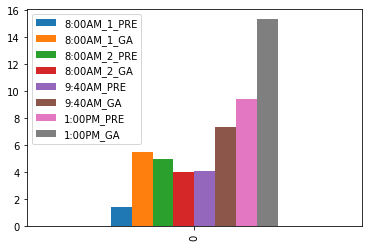

In [139]:
avg_N_interactions10min.plot.bar()

## Whole Data Analytics

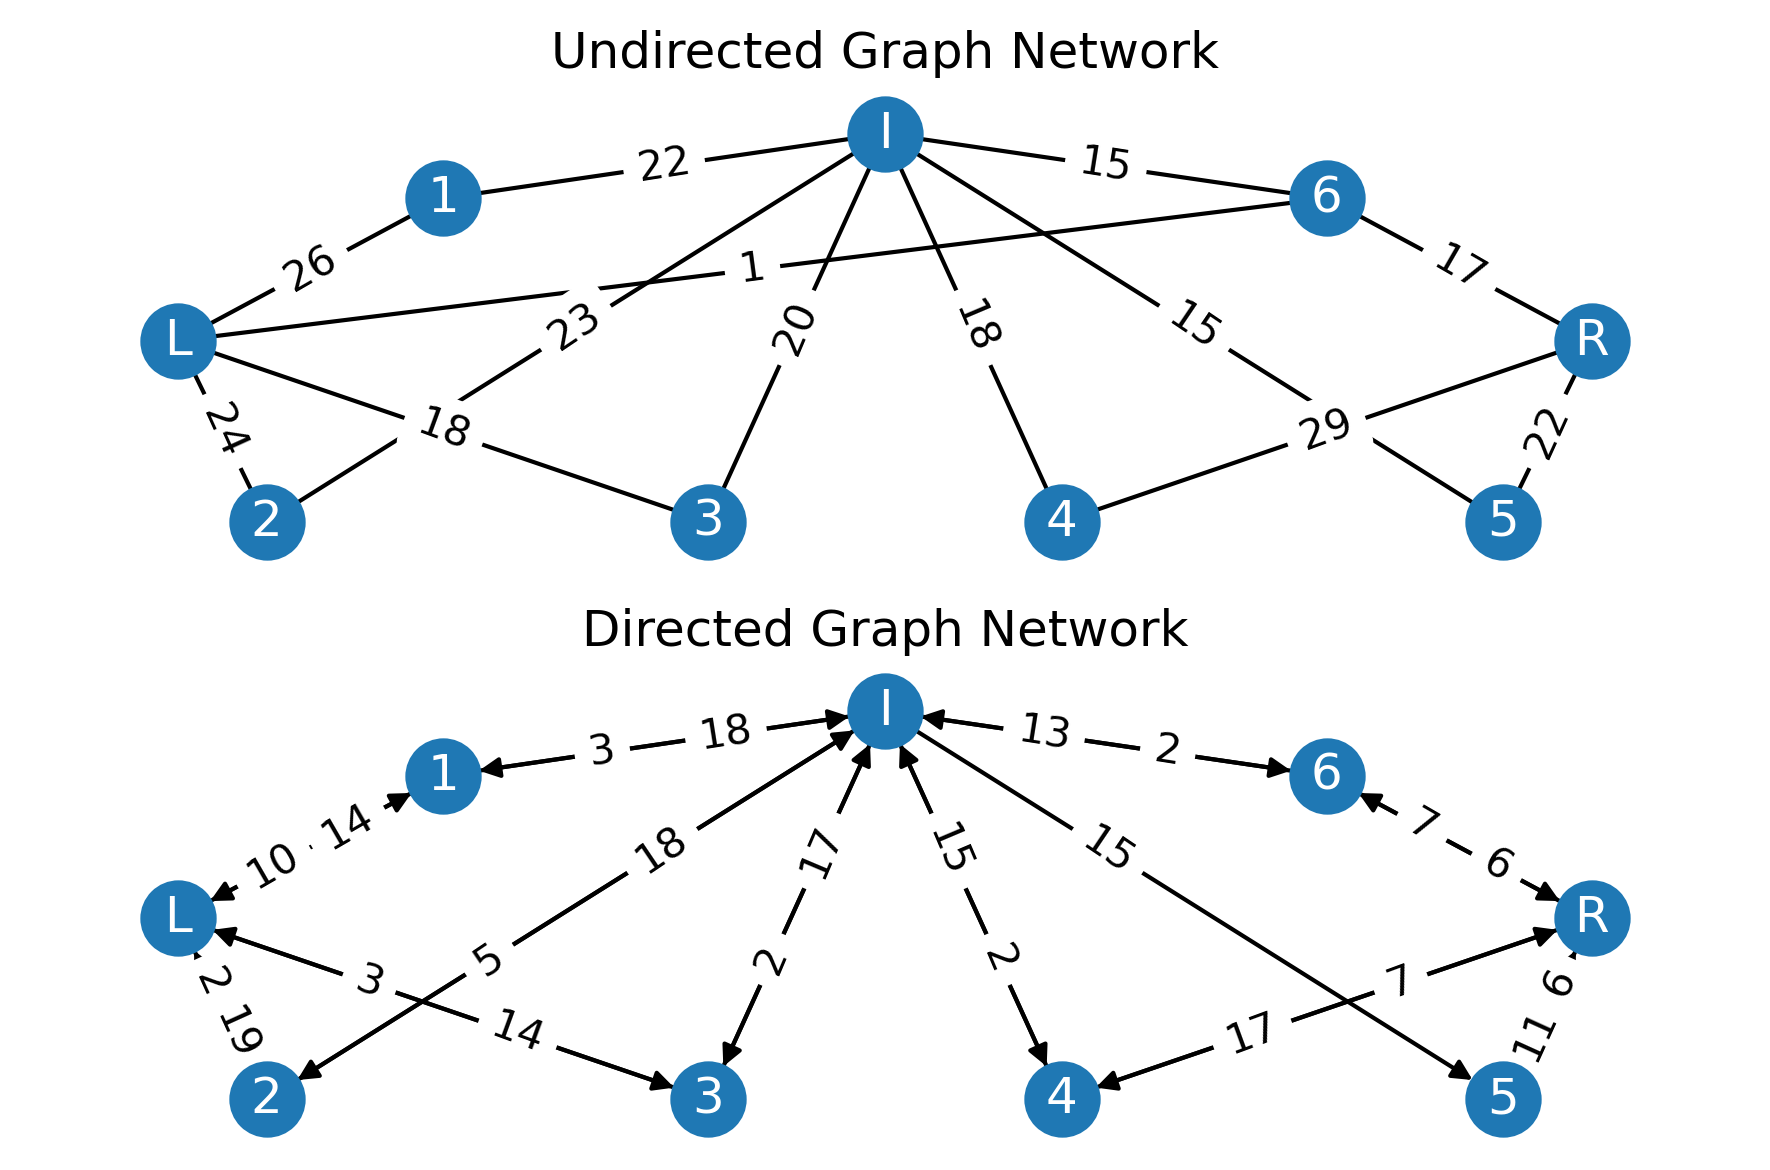

In [172]:
tu = tuesday_data()
tudf = pd.concat(tu, ignore_index=True)
tudf['n'] = tudf['n'].apply(str)
plot_graphs(tudf, include_times=False, label_pos=.64)
plt.savefig("whole-data-graphs.png", dpi=300, bbox_inches='tight')

In [320]:
# def interactions(df):
#     """
#     Returns
#     -------
#     idf : pd.DataFrame
#         DataFrame containing only rows with 
#         interactions
#     """
#     return df.iloc[np.where(~pd.isna(df['S']))].reset_index(drop=True)

def epochs(df):
    """
    Returns
    -------
    epochs_array : np.array
        array with each element having 
        the name and start time for 
        each "epoch" in `df`
    """
    return df.groupby('a').first().reset_index()[['a','t0']].to_numpy()

def to_xr(df):
    """
    Returns
    -------
    ds : xr.Dataset
        Dataset with filled in attributes
    """
    ds = xr.Dataset.from_dataframe(df)
    ds.attrs['epochs'] = epochs(df)
    return ds

##### observation dictionary

In [209]:
obsdict = {
    'M':[monday170],
    'Tu':[
        tuesday150_8am_1,
        tuesday150_8am_2,
        tuesday150_9am,
        tuesday150_1pm
    ],
    'W':[
        wednesday150_9am_1,
        wednesday150_9am_2,
        wednesday150_1pm
    ],
    'Th':[thursday170]
}

obsdata = {}
intxndata = {}
for day, daydata in obsdict.items():
    temp_xrdata = []
    temp_intdata = []
    for i in range(len(daydata)):
        obsdict[day][i] = rename_columns(obsdict[day][i])
        temp_data.append(to_xr(rename_columns(obsdict[day][i])))
        temp_intdata.append(interactions(rename_columns(obsdict[day][i])))
    obsdata[day] = temp_xrdata
    intxndata[day] = temp_intdata

In [102]:
for k,v in intxndata.items():
    for i in range(len(v)):
        vv = v[i]
        try:
            fill_col(vv)
        except:
            print(k, i)

Tu 1
W 0


## Xarray

Kinds of dimensions I want

- time [rows] (size = size of `t0` or `t` array - equivalently, the number of interactions in the data)
- space [columns] (size = number of tables (6))
- 

In [412]:
def format4xr(df, class_start_time:str, minutes:bool=True):
    """
    Reformats the DataFrame `df` for 
    conversion to Xarray
    """
    df_ = df.copy()
    df_['t0'] = df_['t0'].apply(lambda x: pd.Timestamp(str(x)) - pd.Timestamp(class_start_time))
    df_['t']  = df_['t'].apply(lambda x: pd.Timestamp(str(x)) - pd.Timestamp(class_start_time))
    if minutes:
        df_['t0'] = df_['t0'].apply(lambda x: x.seconds / 60)
        df_['t']  = df_['t'].apply(lambda x: x.seconds / 60)
    return df_

def find_initiator(df):
    """
    Adds a column to `df` with the 
    interaction's initiator
    """
    df_ = df.copy()
    for col in ['S','T','I','U']:
        df_[col] = df_[col].fillna(0)
    initiators = []
    for i, row in df_.iterrows():
        initiator = 'S'*(row['S'] != 0) + 'T'*(row['T'] != 0) + 'I'*(row['I'] != 0) + 'U'*(row['U'] != 0)
        initiators.append(initiator)
    df_['initiator'] = initiators
    
    targets = []
    for i, row in df_.iterrows():
        if row['initiator'] == 'S':
            if 
    return df_

In [336]:
tu1.loc[(tu1['S'] != 0) | (~pd.isna(tu1['S']))]

,t0,a,n,S,T,I,U,ID,t,torder,l,c
0,13:06:35,Equipment,6,0,0,1,0,<NA>,13:06:58.296000,1,<,
1,13:06:35,Equipment,5,0,1,0,0,A,13:07:34.222000,2,<,
2,13:06:35,Equipment,3,0,0,1,0,<NA>,13:07:52.694000,3,<,
3,13:06:35,Equipment,2,0,0,1,0,<NA>,13:08:25.054000,4,<,
4,13:10:01,Worksheet/problem-solving,4,0,0,1,0,<NA>,13:10:01.300000,5,<,
...,...,...,...,...,...,...,...,...,...,...,...,...
124,14:05:04,Group Assignment,1,1,0,0,0,<NA>,14:28:44.369000,125,<,student handed in assignment
125,14:05:04,Group Assignment,2,1,0,0,0,B,14:29:59.400000,126,<,Asking/verifying answers
126,14:05:04,Group Assignment,5,0,0,1,0,<NA>,14:30:28.838000,127,~,Asking how group assignment is going to same g...
127,14:05:04,Community building,2,1,0,0,0,<NA>,14:32:01.268000,128,~,Asked when instructor's office hours are/webas...


In [343]:
tu1i = find_initiator(tu1)

In [413]:
tu1i.loc[tu1i['initiator']=='U']

,t0,a,n,S,T,I,U,ID,t,torder,l,c,initiator
21,13:22:46,Equipment,5,0,0,0,1,A,13:23:45.334000,22,<,,U
28,13:22:46,Equipment,2,0,0,0,1,B,13:25:38.366000,29,<,,U
62,13:53:25,Equipment,2,0,0,0,1,B,13:53:40.490000,63,<,Taken over by instructor,U
69,13:53:25,Equipment,1,0,0,0,1,B,13:55:33.683000,70,>,~2 minutes,U
72,13:53:25,Equipment,5,0,0,0,1,A,13:56:46.639000,73,<,,U
73,13:53:25,Community building,2,0,0,0,1,B,NaN,74,<,,U
74,13:53:25,Equipment,4,0,0,0,1,A,13:58:02.695000,75,<,Verifying answer,U
78,13:53:25,Equipment,4,0,0,0,1,A,14:02:34.201000,79,~,,U
92,14:05:04,Group Assignment,4,0,0,0,1,<NA>,14:08:47.905000,93,<,Informing student of their office hours (~30s),U
97,14:05:04,Group Assignment,5,0,0,0,1,A,14:10:31.360000,98,<,,U


In [315]:
tu1.loc[pd.isna(tu1['S'])]

,t0,a,n,S,T,I,U,ID,t,torder,l,c
9,13:12:33,Whole Class Time,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,10,<NA>,
10,13:15:11,Equipment,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,11,<NA>,
15,13:17:31,Whole Class Time,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,16,<NA>,
18,13:21:18,Whole Class Time,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,19,<NA>,Instructor explanations/clarifications
19,13:22:46,Equipment,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,20,<NA>,
31,13:26:40,Whole Class Time,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,32,<NA>,
32,13:28:05,Equipment,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,33,<NA>,
37,13:28:05,Equipment,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,38,<NA>,
40,13:34:04,Whole Class Time,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,41,<NA>,
41,13:35:15,Worksheet/problem-solving,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,42,<NA>,


In [346]:
minute_upsamples_tablegrp = format4xr(tu1, '13:00:00', False).set_index('t').groupby('n').resample('1Min')
minute_upsamples_tablegrp = minute_upsamples_tablegrp.agg({'a':'first', 'S':'sum', 'T':'sum', 'I':'sum', 'U':'sum'})
minute_upsamples_tablegrp

a  S  T  I  U
n t                                                   
1 0 days 00:12:03.436000  Group Assignment  0  1  0  0
  0 days 00:13:03.436000              <NA>  0  0  0  0
  0 days 00:14:03.436000              <NA>  0  0  0  0
  0 days 00:15:03.436000              <NA>  0  0  0  0
  0 days 00:16:03.436000              <NA>  0  0  0  0
...                                    ... .. .. .. ..
6 0 days 01:23:58.296000  Group Assignment  0  0  0  1
  0 days 01:24:58.296000              <NA>  0  0  0  0
  0 days 01:25:58.296000  Group Assignment  1  0  0  0
  0 days 01:26:58.296000  Group Assignment  1  0  0  0
  0 days 01:27:58.296000  Group Assignment  0  0  0  1

[486 rows x 5 columns]

In [406]:
minutesampling = format4xr(tu1, '13:00:00', False).set_index('t').resample('1Min').agg({'S':'sum', 'T':'sum', 'I':'sum', 'U':'sum'})
minutesampling = minutesampling.to_xarray()
minutesampling

<xarray.Dataset>
Dimensions:  (t: 87)
Coordinates:
  * t        (t) timedelta64[ns] 00:06:58.296000 ... 01:32:58.296000
Data variables:
    S        (t) object 0 0 0 0 0 0 0 0 0 0 4 0 1 ... 3 0 1 0 3 1 1 1 0 1 0 1 1
    T        (t) object 0 0 0 0 0 0 0 0 0 0 2 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
    I        (t) object 0 0 0 0 0 0 0 0 0 0 7 0 0 ... 0 0 0 0 0 0 2 1 0 1 0 0 0
    U        (t) object 0 0 0 0 0 0 0 0 0 0 1 0 0 ... 0 0 0 2 0 0 0 1 0 0 0 0 0

In [ ]:
minutesampling.

In [359]:
format4xr(tu1, '13:00:00', False)

,t0,a,n,S,T,I,U,ID,t,torder,l,c
0,0 days 00:06:35,Equipment,6,0,0,1,0,<NA>,0 days 00:06:58.296000,1,<,
1,0 days 00:06:35,Equipment,5,0,1,0,0,A,0 days 00:07:34.222000,2,<,
2,0 days 00:06:35,Equipment,3,0,0,1,0,<NA>,0 days 00:07:52.694000,3,<,
3,0 days 00:06:35,Equipment,2,0,0,1,0,<NA>,0 days 00:08:25.054000,4,<,
4,0 days 00:10:01,Worksheet/problem-solving,4,0,0,1,0,<NA>,0 days 00:10:01.300000,5,<,
...,...,...,...,...,...,...,...,...,...,...,...,...
124,0 days 01:05:04,Group Assignment,1,1,0,0,0,<NA>,0 days 01:28:44.369000,125,<,student handed in assignment
125,0 days 01:05:04,Group Assignment,2,1,0,0,0,B,0 days 01:29:59.400000,126,<,Asking/verifying answers
126,0 days 01:05:04,Group Assignment,5,0,0,1,0,<NA>,0 days 01:30:28.838000,127,~,Asking how group assignment is going to same g...
127,0 days 01:05:04,Community building,2,1,0,0,0,<NA>,0 days 01:32:01.268000,128,~,Asked when instructor's office hours are/webas...


In [ ]:
xr.DataArray(format4xr(tu1, '13:00:00', False)[['S', 'T', 'I', 'U'

In [378]:
minups_a_table_grp = format4xr(tu1, '13:00:00', False).set_index('t').groupby(['a', 'n']).resample('1Min')
minups_a_table_grp = minups_a_table_grp.agg({'S':'sum', 'T':'sum', 'I':'sum', 'U':'sum'})
minups_a_table_grp = minups_a_table_grp.to_xarray().fillna({'S':0, 'T':0, 'I':0, 'U':0})
minups_a_table_grp

<xarray.Dataset>
Dimensions:  (a: 4, n: 6, t: 489)
Coordinates:
  * a        (a) object 'Community building ' ... 'Worksheet/problem-solving'
  * n        (n) object 1 2 3 4 5 6
  * t        (t) timedelta64[ns] 00:06:58.296000 ... 01:32:52.805000
Data variables:
    S        (a, n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    T        (a, n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    I        (a, n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    U        (a, n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [379]:
minups_a_table_grp.sel(a='Group Assignment')

<xarray.Dataset>
Dimensions:  (n: 6, t: 489)
Coordinates:
    a        <U16 'Group Assignment'
  * n        (n) object 1 2 3 4 5 6
  * t        (t) timedelta64[ns] 00:06:58.296000 ... 01:32:52.805000
Data variables:
    S        (n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    T        (n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    I        (n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    U        (n, t) object 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

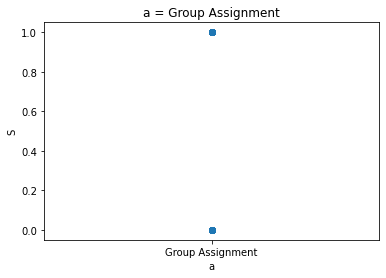

In [397]:
minups_a_table_grp.sel(a='Group Assignment').plot.scatter('a', 'S')

## v1

In [230]:
tues = obsdict['Tu']

# fill all `t0` and `a` columns in each DataFrame 
tues = [fill_col(fill_col(df, col='t0'),col='a') for df in tues]

# TA `R` = TA's on RHS of room (the side with tables 4, 5, 6)
# TA `L` = TA's on LHS of room (the side with tables 1, 2, 3)

# `tues` ordering
# tuesday150_8am_1
#     R = A
#     L = B
# tuesday150_8am_2
#     R = A
#     L = B
# tuesday150_9am
#     R = R
#     L = A
# tuesday150_1pm
#     R = A
#     L = B

tues_start_times = [
    '8:00',
    '8:00',
    '9:40',
    '13:00'
]

# normalized times
normtues = []
for i, df in enumerate(tues):
    ndf = df.copy()
    ndf['t0'] = ndf['t0'].apply(lambda x: pd.Timestamp(str(x)) - pd.Timestamp(tues_start_times[i]))
    normtues.append(ndf)

tues_TA_mapping = [
    {'A':'R', 'B':'L'},
    {'A':'R', 'B':'L'},
    {'R':'R', 'A':'L'},
    {'A':'R', 'B':'L'}
]

# for i, df in enumerate(tues):
#     newIDs = []
#     for ID in df['ID']:
#         if ID in tues_TA_mapping[i].keys():
#             newIDs.append(tues_TA_mapping[i][ID])
#         elif pd.isna(ID):
#             newIDs.append(None)
#         else:
#             newIDs.append('I')
#     df['ID'] = newIDs
#     # df = df.convert_dtypes()
#     # df['ID'] = df['ID'].astype('category')
#     df['ID'].fillna(value=np.nan, inplace=True)

In [221]:
normtues

[                t0                          a     n     S     T     I     U  \
 0  0 days 00:05:00                   iClicker     3     1  <NA>  <NA>  <NA>   
 1  0 days 00:07:00           Whole Class time  <NA>  <NA>  <NA>  <NA>  <NA>   
 2  0 days 00:09:00  Worksheet/Problem Solving     1  <NA>     1  <NA>  <NA>   
 3  0 days 00:09:00  Worksheet/Problem Solving     2  <NA>  <NA>     1  <NA>   
 4  0 days 00:09:00  Worksheet/Problem Solving     3  <NA>     1  <NA>  <NA>   
 5  0 days 00:09:00  Worksheet/Problem Solving     1  <NA>     1  <NA>  <NA>   
 6  0 days 00:20:00           Whole Class time  <NA>  <NA>  <NA>  <NA>  <NA>   
 7  0 days 00:25:00  Worksheet/Problem Solving     3  <NA>     1  <NA>  <NA>   
 8  0 days 00:31:00           Whole Class time  <NA>  <NA>  <NA>  <NA>  <NA>   
 9  0 days 00:31:00                   iClicker  <NA>  <NA>  <NA>  <NA>  <NA>   
 10 0 days 00:33:00  Worksheet/Problem Solving     1  <NA>  <NA>     1  <NA>   
 11 0 days 00:36:00           Whole Clas

In [200]:
testdatetime = tues[0]['t'][0]

In [204]:
testdf = tues[0]
testdf['t'] = testdf['t'].apply(lambda x: pd.Timestamp(str(x)))
pd.DataFrame(testdf.groupby('t').size(), columns=['counts']).resample("Min")#, method='bfill')

In [196]:
pd.DataFrame(tues[0].groupby('a').size(), columns=['counts'])

,counts
a,
Group Assignment,13
Table 1 all left,2
Table 3 all left,2
Whole Class Time,2
Whole Class Time/iClicker,1
Whole Class time,4
Whole Class time/iClicker,1
Worksheet/Problem Solving,19
iClicker,4


In [195]:
pd.DataFrame(tues[0].groupby(['t', 'a']).size(), columns=['counts']).reset_index()

,t,a,counts
0,08:06:00,iClicker,1
1,08:12:00,Worksheet/Problem Solving,2
2,08:15:00,Worksheet/Problem Solving,1
3,08:19:00,Worksheet/Problem Solving,1
4,08:30:00,Worksheet/Problem Solving,1
5,08:34:00,Worksheet/Problem Solving,1
6,08:45:00,Worksheet/Problem Solving,1
7,08:48:00,Whole Class Time/iClicker,1
8,08:59:00,Worksheet/Problem Solving,1
9,09:03:00,Worksheet/Problem Solving,1


In [188]:
tues[0]['t'].astype('category')[0]

datetime.time(8, 6)

In [177]:
tues[0]['t'][0]

datetime.time(8, 6)

In [173]:
[df['t'].unique() for df in tues]

[array([datetime.time(8, 6), nan, datetime.time(8, 12),
        datetime.time(8, 15), datetime.time(8, 19), datetime.time(8, 30),
        datetime.time(8, 34), datetime.time(8, 45), datetime.time(8, 48),
        datetime.time(8, 59), datetime.time(9, 3), datetime.time(9, 4),
        datetime.time(9, 5), datetime.time(9, 6), datetime.time(9, 8),
        datetime.time(9, 9), datetime.time(9, 11), datetime.time(9, 13),
        datetime.time(9, 16), datetime.time(9, 17), datetime.time(9, 19),
        datetime.time(9, 20), datetime.time(9, 21), datetime.time(9, 22),
        datetime.time(9, 23), datetime.time(9, 25)], dtype=object),
 array([datetime.time(8, 5), datetime.time(8, 7), datetime.time(8, 8),
        datetime.time(8, 10), nan, datetime.time(8, 15),
        datetime.time(8, 16), datetime.time(8, 17), datetime.time(8, 18),
        datetime.time(8, 19), datetime.time(8, 20), datetime.time(8, 27),
        datetime.time(8, 28), datetime.time(8, 29), datetime.time(8, 30),
        dateti

In [235]:
normtues[-1].groupby('a').first().sort_values('t0')

,t0,n,S,T,I,U,ID,t,torder,l,c
a,,,,,,,,,,,
Equipment,0 days 00:06:35,5,0,1,0,0,A,13:07:34.222000,2,<,
Worksheet/problem-solving,0 days 00:10:01,4,0,0,1,0,A,13:10:01.300000,5,<,
Whole Class Time,0 days 00:12:33,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,None,10,<NA>,
Community building,0 days 00:19:08,4,0,0,1,0,B,13:21:03.531000,18,<,
iClicker,0 days 00:40:05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,None,49,<NA>,
Group Assignment,0 days 01:05:04,5,1,0,0,0,A,14:05:39.484000,83,<,


In [ ]:
normtues[-1].groupby('a').first().sort_values

In [236]:
normtues[2].groupby('a').first().sort_values('t0')

,t0,n,S,T,I,U,ID,t,torder,l,c
a,,,,,,,,,,,
Folcrum,0 days 00:13:00,4,1,<NA>,1,1,R,09:53:00,2,<1min,<NA>
Open question,0 days 00:17:00,1,<NA>,<NA>,1,<NA>,<NA>,None,6,<1min,Explanation to an open question from instructor
Balance,0 days 00:21:00,6,1,1,1,1,A,10:14:00,7,<1min,Professor was giving midterms (Possibly just c...
iCliker,0 days 00:42:00,5,<NA>,<NA>,1,<NA>,<NA>,10:22:00,17,>1min,Dr.Mehta approached to ask the table what they...
CofG,0 days 01:00:00,4,1,1,1,1,A,10:40:00,23,<1min,About 7 min of interaction
Written Assignment,0 days 01:12:00,2,1,1,1,1,A,10:52:00,36,1min,Question to instructor


In [211]:
tues[2]

,t0,a,n,S,T,I,U,ID,t,torder,l,c
0,09:53:00,Folcrum,4,1,<NA>,<NA>,<NA>,R,09:53:00,2,<1min,<NA>
1,09:55:00,Folcrum,1,<NA>,<NA>,1,<NA>,<NA>,NaN,3,<1min,<NA>
2,09:55:00,Folcrum,5,<NA>,<NA>,<NA>,1,R,09:55:00,4,<1min,<NA>
3,09:57:00,Folcrum,3,<NA>,<NA>,1,<NA>,<NA>,09:57:00,5,>1min,<NA>
4,09:57:00,Open question,1,<NA>,<NA>,1,<NA>,<NA>,NaN,6,<1min,Explanation to an open question from instructor
5,10:01:00,Balance,6,<NA>,<NA>,<NA>,1,<NA>,NaN,7,<1min,<NA>
6,10:07:00,Balance,1,1,<NA>,<NA>,<NA>,A,NaN,8,<1min,<NA>
7,10:07:00,Balance,5,<NA>,<NA>,<NA>,1,<NA>,NaN,9,<1min,Professor was giving midterms (Possibly just c...
8,10:09:00,Balance,3,<NA>,1,<NA>,<NA>,A,NaN,10,<1min,<NA>
9,10:09:00,Balance,1,<NA>,1,<NA>,<NA>,A,NaN,11,<1min,Explanation of experiment


In [172]:
[df['a'].unique() for df in tues]

[array(['iClicker', 'Whole Class time', 'Worksheet/Problem Solving',
        'Whole Class time/iClicker', 'Whole Class Time/iClicker',
        'Whole Class Time', 'whole class time', 'Group Assignment ',
        'Table 3 all left', 'Table 1 all left'], dtype=object),
 array(['describing activity for the day', 'Poll using clickers',
        'center of balance setup/question 2 of WS/ torque understanding',
        'instructor re-addresses class for explaining the system',
        'balancing ruler on hand acitivty to understand center of gravity',
        'TA hands out rulers', 'Instructor hands out rulers',
        'instructor address class', 'clicker question',
        'working on balancing part ABCD of question 4',
        'instructor shows the correct answer for clicker question',
        'new clicker question',
        'testing clicker question proposed ruler balance',
        'instructor readdresses class',
        'students testing clicker question scenerio',
        'new clicker q

In [169]:
tues[0]['ID'].unique().tolist()

['instructor', <NA>, 'B']

In [170]:
[df['ID'].unique().tolist() for df in tues]

[['instructor', <NA>, 'B'], [<NA>, 'A'], ['R', <NA>, 'A'], ['A', <NA>, 'B']]

In [149]:
pd.to_numeric(np.nan)

nan

In [163]:
def df2digraph(df, mapping_index):
    """
    Returns
    -------
    digraph : nx.DiGraph
        Directed graph network of the 
        interactions contained in `df`
    """
    # create an edgelist DataFrame with 
    # "source" and "target" columns
    source = []
    target = []
    for i, row in df.iterrows():
        if ~pd.isna(row['n']):
            if pd.api.types.is_numeric_dtype(row['S']):
                if row['S'] != 0:
                    source.append(row['n'])
                    target.append(tues_TA_mapping[mapping_index][row['ID']])
            elif pd.api.types.is_numeric_dtype(row['T']):
                if row['T'] != 0:
                    source.append(tues_TA_mapping[mapping_index][row['ID']])
                    target.append(row['n'])
            elif pd.api.types.is_numeric_dtype(row['I']):
                if row['I'] != 0:
                    source.append('I')
                    target.append(row['n'])
            elif pd.api.types.is_numeric_dtype(row['U']):
                if row['U'] != 0:
                    source.append('U')
                    target.append(row['n'])
        else:
            source.append(np.nan)
            target.append(np.nan)
            
    print(source, target)
    df_copy = df.assign(source = source)
    df_copy = df_copy.assign(target=target)
    # edgelist_df = pd.DataFrame({'source':source, 'target':target})
    grp_interactions = pd.DataFrame(df.groupby(['source', 'target']).size(), columns=['counts']).reset_index()
    digraph = nx.from_pandas_edgelist(grp_interactions, source='source', target='target', create_using=nx.DiGraph())
    return digraph

In [165]:
df2digraph(tues[0], 0)

[] []


ValueError: Length of values (0) does not match length of index (49)

In [168]:
pd.to_numeric(tues[0]['S'])

0        1
1     <NA>
2     <NA>
3     <NA>
4     <NA>
5     <NA>
6     <NA>
7     <NA>
8     <NA>
9     <NA>
10    <NA>
11    <NA>
12    <NA>
13    <NA>
14    <NA>
15    <NA>
16    <NA>
17    <NA>
18    <NA>
19    <NA>
20    <NA>
21    <NA>
22    <NA>
23    <NA>
24    <NA>
25    <NA>
26    <NA>
27       1
28       1
29       1
30       1
31    <NA>
32    <NA>
33       1
34       1
35    <NA>
36    <NA>
37    <NA>
38       1
39       1
40       1
41       1
42    <NA>
43       1
44    <NA>
45    <NA>
46       1
47    <NA>
48    <NA>
Name: S, dtype: Int64

## V2

### Combining 8am data

In [252]:
rename_columns(tuesday150_8am_1)['n'].unique()

<IntegerArray>
[<NA>, 3, 1, 2]
Length: 4, dtype: Int64

In [250]:
tues8L = tuesday150_8am_1
tues8R = tuesday150_8am_2

In [253]:
tuesday150_9am['classroom  activity'].unique()

array(['Open question', 'Folcrum', 'Balance', 'iCliker', 'CofG',
       'Written Assignment'], dtype=object)

In [ ]:
def reformat_tues_9am(df):
    reformat_dict = {'Open question':'Whole Class Time'

In [247]:
tues8L

,Activity,classroom activity,for Interaction,Initiated,Initiated,Initiated.1,Initiation,A or B,of interaction,Time Order,"<, ~, > 1 min",Comments
0,08:02:00,Whole Class time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,lecture and intro on torque; review of center ...
1,08:05:00,iClicker,3.0,1.0,NaN,NaN,NaN,instructor,08:06:00,2,< 1 min,with instructor; problem 1
2,08:07:00,Whole Class time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
3,08:09:00,Worksheet/Problem Solving,1.0,NaN,1.0,NaN,NaN,B,08:12:00,4,< 1 min,Could also mix with equipment - using meter st...
4,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,08:12:00,5,< 1 min,problem 2
5,NaN,NaN,3.0,NaN,1.0,NaN,NaN,B,08:15:00,6,1 min,clarified approach; problem 2
6,NaN,NaN,1.0,NaN,1.0,NaN,NaN,B,08:19:00,7,< 1 min,problem 2; asking their approach/conclusions; ...
7,08:20:00,Whole Class time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Clarifying Problem 2, showing correct answer; ..."
8,08:25:00,Worksheet/Problem Solving,3.0,NaN,1.0,NaN,NaN,B,08:30:00,9,< 1 min,clarification; fixing the equipment
9,08:31:00,Whole Class time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,review of problem 3 results
